# Imports/Setup

In [1]:
import os
import sys
import time

import numpy as np

from astropy import units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord, Angle

import astroquery

import tqdm

from importlib import reload

%matplotlib inline
from matplotlib import style, pyplot as plt

In [2]:
working_dir = os.path.abspath('..')

%cd ../../saga
sagadir = !pwd
sagadir = sagadir[0]
!python setup.py build
%cd $working_dir

/Users/erik/projects/saga/saga
running build
running build_py
/Users/erik/projects/saga/erik


In [4]:
sagalibdir = os.path.join(sagadir, 'build/lib')
print('Adding', sagalibdir, 'to the python path')
sys.path.insert(0, sagalibdir)

import SAGA as saga

Adding /Users/erik/projects/saga/saga/build/lib to the python path


In [5]:
saga_database = saga.Database(os.path.join(os.environ['HOME'],'Dropbox/SAGA/'), working_dir)
saga_field_catalog = saga.FieldCatalog(saga_database)
saga_object_catalog = saga.ObjectCatalog(saga_database, saga.FieldCatalog)

# Get Data

## DES Catalogs 

In [8]:
fields = saga_field_catalog.load()

failed = saga.database.download_catalogs_for_hosts(fields, saga.database.DesQuery, 
                                                   saga_database.des_file_path_pattern, 
                                                   overwrite=False, host_id_label='field_id')
print('# failed =', np.count_nonzero(failed))

[07/20 16:19:27] Getting catalog for host Phoenix_1 ...
[07/20 16:19:27] Getting catalog for host Phoenix_2 ...
[07/20 16:19:27] Getting catalog for host Phoenix_3 ...
[07/20 16:19:27] Getting catalog for host Phoenix_4 ...
[07/20 16:19:27] Getting catalog for host Phoenix_5 ...
[07/20 16:19:27] Getting catalog for host Phoenix_6 ...
[07/20 16:19:27] Getting catalog for host Phoenix_7 ...
[07/20 16:19:27] Getting catalog for host Indus_1 ...
[07/20 16:19:27] Getting catalog for host Indus_2 ...
[07/20 16:19:27] Getting catalog for host Indus_3 ...
[07/20 16:19:27] Getting catalog for host Indus_4 ...
[07/20 16:19:27] Getting catalog for host Indus_5 ...
[07/20 16:19:27] Getting catalog for host Indus_6 ...
[07/20 16:19:27] Getting catalog for host Indus_7 ...
[07/20 16:19:27] Getting catalog for host Indus_8 ...
[07/20 16:19:27] Getting catalog for host Indus_9 ...
[07/20 16:19:27] Getting catalog for host Indus_10 ...
[07/20 16:19:27] Getting catalog for host Jhelum_1 ...
[07/20 16:19

## Gaia Catalogs 

First we create async objects for *every* one of these fields

In [11]:
from astroquery.gaia import Gaia

from getpass import getpass

Gaia.login(input('username:'), getpass('pw:'))

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [12]:
# this hides the warnings from parsing VOTables from Gaia

import warnings
from astropy.io.votable.exceptions import VOTableSpecWarning

warnings.simplefilter('ignore', VOTableSpecWarning)

In [14]:
gaiajobs = {}
for field in fields:
    fnm = field['field_id']
    fn = 'external_catalogs/astrometric/{}_gaia.ecsv'.format(fnm)
    if os.path.exists(fn):
        print('File', fn, 'exists, skipping.')
        continue
    else:
        print('Starting job for', fnm)
    gaiajob = Gaia.cone_search_async(field['coord'], radius=1*u.deg, background=True)
    gaiajobs[fnm] = gaiajob

File external_catalogs/astrometric/Phoenix_1_gaia.ecsv exists, skipping.
File external_catalogs/astrometric/Phoenix_2_gaia.ecsv exists, skipping.
File external_catalogs/astrometric/Phoenix_3_gaia.ecsv exists, skipping.
File external_catalogs/astrometric/Phoenix_4_gaia.ecsv exists, skipping.
File external_catalogs/astrometric/Phoenix_5_gaia.ecsv exists, skipping.
File external_catalogs/astrometric/Phoenix_6_gaia.ecsv exists, skipping.
File external_catalogs/astrometric/Phoenix_7_gaia.ecsv exists, skipping.
File external_catalogs/astrometric/Indus_1_gaia.ecsv exists, skipping.
File external_catalogs/astrometric/Indus_2_gaia.ecsv exists, skipping.
File external_catalogs/astrometric/Indus_3_gaia.ecsv exists, skipping.
File external_catalogs/astrometric/Indus_4_gaia.ecsv exists, skipping.
File external_catalogs/astrometric/Indus_5_gaia.ecsv exists, skipping.
File external_catalogs/astrometric/Indus_6_gaia.ecsv exists, skipping.
File external_catalogs/astrometric/Indus_7_gaia.ecsv exists, sk

In [15]:
#check phases
nqueued = 0
ncompleted = 0
nother = 0
for nm, job in gaiajobs.items():
    ph = job.get_phase(True)
    print(nm, job.get_jobid(), ph)
    if ph == 'QUEUED':
        nqueued += 1
    elif ph == 'COMPLETED':
        ncompleted += 1
    else:
        nother +=1
nall = nqueued + ncompleted + nother
print('q:{:%}, c:{:%}, o:{:%}'.format(nqueued/nall, ncompleted/nall, nother/nall))

Ravi_0 1532118227439O COMPLETED
ATLAS_0 1532118228095O COMPLETED
ATLAS_1 1532118228723O COMPLETED
ATLAS_2 1532118229349O COMPLETED
ATLAS_3 1532118229964O COMPLETED
ATLAS_4 1532118230585O COMPLETED
ATLAS_5 1532118232087O COMPLETED
ATLAS_6 1532118232722O COMPLETED
ATLAS_7 1532118233361O COMPLETED
ATLAS_8 1532118233994O COMPLETED
ATLAS_9 1532118234498O COMPLETED
ATLAS_10 1532118235002O COMPLETED
q:0.000000%, c:100.000000%, o:0.000000%


In [21]:
saved = []

with tqdm.tqdm_notebook(total=len(gaiajobs)) as pbar:
    nq = np.inf
    while nq > 0 and len(saved)< len(gaiajobs):
        print('\r', end='')
        print('still have {} queued and {} saved of {} ... sleeping'.format(nq, len(saved), len(gaiajobs)), end='')
        if nq != np.inf:
            time.sleep(60)
        pbar.unpause()
        
        nq = 0
        for fnm, job in gaiajobs.items():
            ph = job.get_phase(True)
            if ph == 'COMPLETED' and fnm not in saved:
                print('\r', end='')
                print('Loading', fnm, end=' ... ')
                gaia_data = job.get_data()
                fn = 'external_catalogs/astrometric/{}_gaia.ecsv'.format(fnm)
                print('Writing', fnm, 'to', fn)
                gaia_data.write(fn, format='ascii.ecsv')
                saved.append(fnm)
                pbar.update(1)
            elif ph =='QUEUED':
                nq += 1

HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

Loading Ravi_0 ... Writing Ravi_0 to external_catalogs/astrometric/Ravi_0_gaia.ecsv
Loading ATLAS_0 ... Writing ATLAS_0 to external_catalogs/astrometric/ATLAS_0_gaia.ecsv
Loading ATLAS_1 ... Writing ATLAS_1 to external_catalogs/astrometric/ATLAS_1_gaia.ecsv
Loading ATLAS_2 ... Writing ATLAS_2 to external_catalogs/astrometric/ATLAS_2_gaia.ecsv
Loading ATLAS_3 ... Writing ATLAS_3 to external_catalogs/astrometric/ATLAS_3_gaia.ecsv
Loading ATLAS_4 ... Writing ATLAS_4 to external_catalogs/astrometric/ATLAS_4_gaia.ecsv
Loading ATLAS_5 ... Writing ATLAS_5 to external_catalogs/astrometric/ATLAS_5_gaia.ecsv
Loading ATLAS_6 ... Writing ATLAS_6 to external_catalogs/astrometric/ATLAS_6_gaia.ecsv
Loading ATLAS_7 ... Writing ATLAS_7 to external_catalogs/astrometric/ATLAS_7_gaia.ecsv
Loading ATLAS_8 ... Writing ATLAS_8 to external_catalogs/astrometric/ATLAS_8_gaia.ecsv
Loading ATLAS_9 ... Writing ATLAS_9 to external_catalogs/astrometric/ATLAS_9_gaia.ecsv
Loading ATLAS_10 ... Writing ATLAS_10 to exter

# Comparisons 

In [111]:
def get_offsets(fieldname, gaiafn, doplot=False, 
                septhresh=1.5*u.arcsec, 
                gaia_magrng=(16, 17), d_matchmag=1,
                biweight=False, des_table=None):
    if des_table is None:
        des_table = saga_database['des', fieldname].read()
    gaia_table = Table.read(gaiafn, format='ascii.ecsv')
    
    dsc = SkyCoord(des_table['ra'], des_table['dec'], unit=u.deg)
    dmag = des_table['r_mag']
    dsc_msk = dsc[(gaia_magrng[0]<dmag)&(dmag<gaia_magrng[1])]
    
    sc = SkyCoord(gaia_table['ra'], gaia_table['dec'], unit=u.deg)
    mag = gaia_table['phot_g_mean_mag']
    sc_msk = sc[((gaia_magrng[0]-d_matchmag)<mag)&(mag<(gaia_magrng[1]+d_matchmag))]
    
    idx, d2d, _ = dsc_msk.match_to_catalog_sky(sc_msk)
    dra = dsc_msk.ra - sc_msk[idx].ra
    dracosdec = dra*np.cos(dsc_msk.dec)
    ddec = dsc_msk.dec - sc_msk[idx].dec
    
    sepmsk = d2d < septhresh
    
    if biweight:
        from astropy.stats import biweight_location as meanfunc
    else:
        meanfunc = np.mean
        
    meanra = meanfunc(dra[sepmsk]).to(u.arcsec)
    meanracosdec = meanfunc(dracosdec[sepmsk]).to(u.arcsec)
    meandec = meanfunc(ddec[sepmsk]).to(u.arcsec)
    
    if doplot:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        ax1.hist(d2d.arcsec, bins=100)

        ax2.scatter(dra[sepmsk].arcsec, ddec[sepmsk].arcsec, alpha=.4)
        ax2.scatter([0], [0], c='k', s=10)
        ax2.scatter([meanra.value], [meandec.value], c='r', s=10)
        ax2.set_xlim(-septhresh.to(u.arcsec).value, septhresh.to(u.arcsec).value)
        ax2.set_ylim(-septhresh.to(u.arcsec).value, septhresh.to(u.arcsec).value)
        fmt = (meanracosdec.value, meandec.value, 
               np.std(dracosdec[sepmsk]).arcsec, np.std(ddec[sepmsk]).arcsec, 
               np.mean(d2d[sepmsk]).arcsec, np.std(d2d[sepmsk]).arcsec)
        ax2.set_title('$\\Delta \\alpha={:.2f}$ $\\Delta \\delta={:.2f}$ \n $\\sigma_\\alpha={:.2f}, \\sigma_\\delta={:.2f}$ \n $\\mu={:.2f}$ $\\sigma={:.2f}$'.format(*fmt))

        ax1.set_title(fieldname)
    return meanra, meanracosdec, meandec

HBox(children=(IntProgress(value=0, max=101), HTML(value='')))

Offsets for Phoenix_1 are: (<Angle -0.25346812 arcsec>, <Angle -0.1842277 arcsec>, <Angle 0.04928131 arcsec>)
Offsets for Phoenix_2 are: (<Angle -0.1910693 arcsec>, <Angle -0.13458018 arcsec>, <Angle 0.05450962 arcsec>)
Offsets for Phoenix_3 are: (<Angle -0.26176879 arcsec>, <Angle -0.17788102 arcsec>, <Angle 0.05653023 arcsec>)
Offsets for Phoenix_4 are: (<Angle -0.26903383 arcsec>, <Angle -0.17650497 arcsec>, <Angle 0.06490215 arcsec>)
Offsets for Phoenix_5 are: (<Angle -0.28473702 arcsec>, <Angle -0.17937578 arcsec>, <Angle 0.08082097 arcsec>)
Offsets for Phoenix_6 are: (<Angle -0.22345142 arcsec>, <Angle -0.13521503 arcsec>, <Angle 0.078116 arcsec>)
Offsets for Phoenix_7 are: (<Angle -0.27923927 arcsec>, <Angle -0.16201287 arcsec>, <Angle 0.03070144 arcsec>)
Offsets for Indus_1 are: (<Angle -0.3368618 arcsec>, <Angle -0.14653741 arcsec>, <Angle 0.08281397 arcsec>)
Offsets for Indus_2 are: (<Angle -0.33242585 arcsec>, <Angle -0.15060137 arcsec>, <Angle 0.12291888 arcsec>)
Offsets fo

/Users/erik/miniconda3/envs/saga3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Offsets for Jhelum_4 are: (<Angle -0.21293941 arcsec>, <Angle -0.13176456 arcsec>, <Angle 0.10110895 arcsec>)
Offsets for Jhelum_5 are: (<Angle -0.21553763 arcsec>, <Angle -0.13387273 arcsec>, <Angle 0.10202628 arcsec>)
Offsets for Jhelum_6 are: (<Angle -0.16089161 arcsec>, <Angle -0.10082176 arcsec>, <Angle 0.12086273 arcsec>)
Offsets for Jhelum_7 are: (<Angle -0.19865142 arcsec>, <Angle -0.12522516 arcsec>, <Angle 0.13676895 arcsec>)
Offsets for Jhelum_8 are: (<Angle -0.15299176 arcsec>, <Angle -0.09720834 arcsec>, <Angle 0.10672879 arcsec>)
Offsets for Jhelum_9 are: (<Angle -0.11117997 arcsec>, <Angle -0.07151698 arcsec>, <Angle 0.14343121 arcsec>)
Offsets for Jhelum_10 are: (<Angle -0.15836711 arcsec>, <Angle -0.10315015 arcsec>, <Angle 0.11937074 arcsec>)
Offsets for Jhelum_11 are: (<Angle -0.14247427 arcsec>, <Angle -0.09420504 arcsec>, <Angle 0.12630313 arcsec>)
Offsets for Jhelum_12 are: (<Angle -0.14898744 arcsec>, <Angle -0.09948417 arcsec>, <Angle 0.12521727 arcsec>)
Offsets

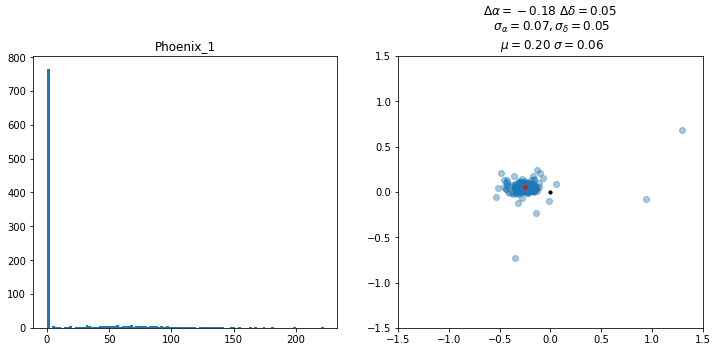

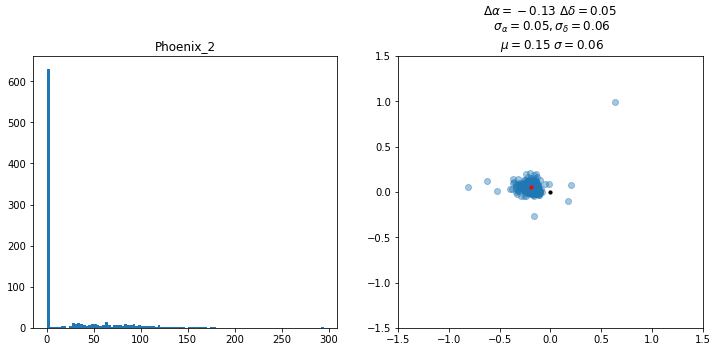

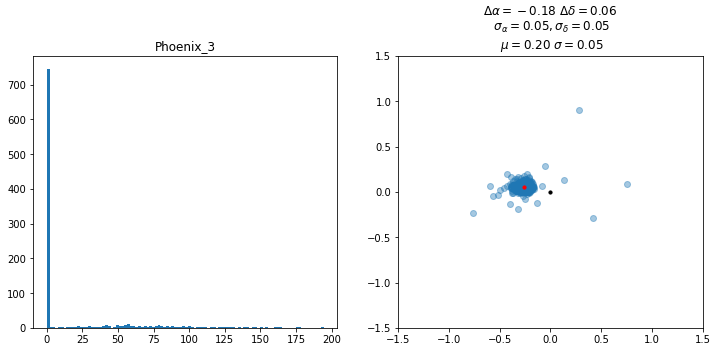

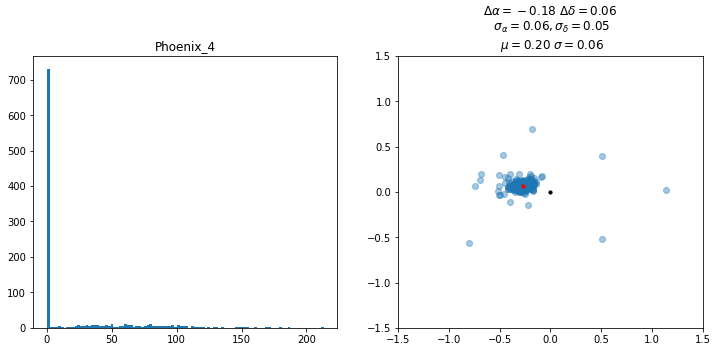

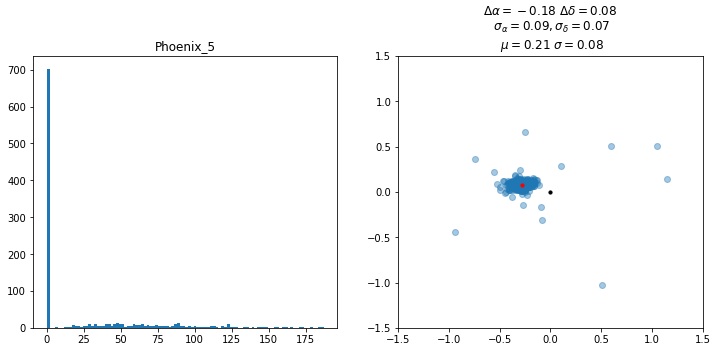

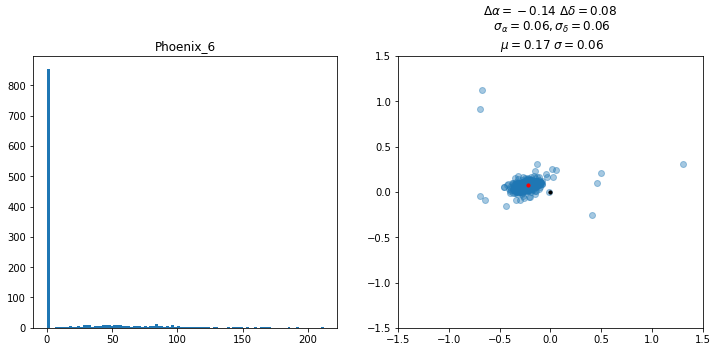

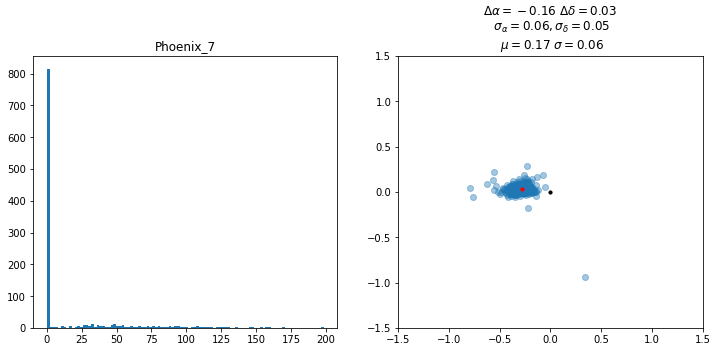

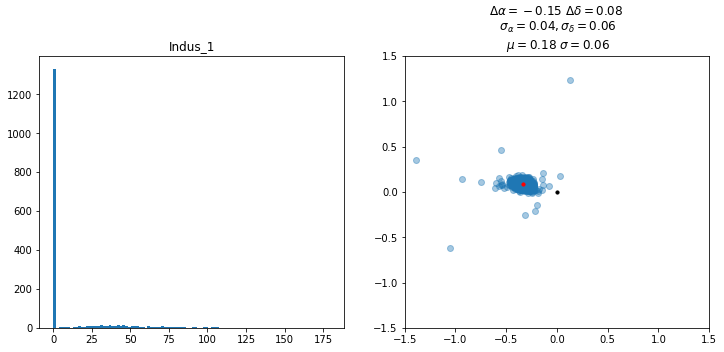

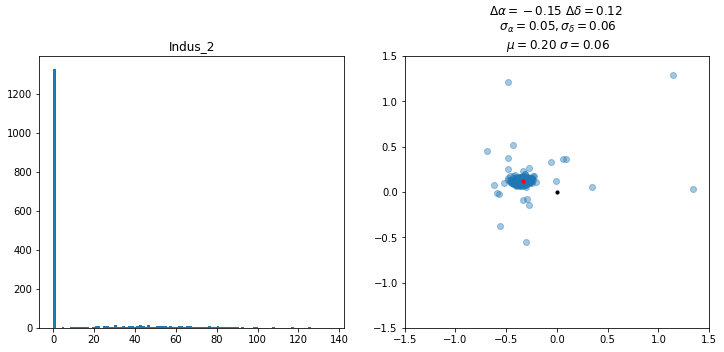

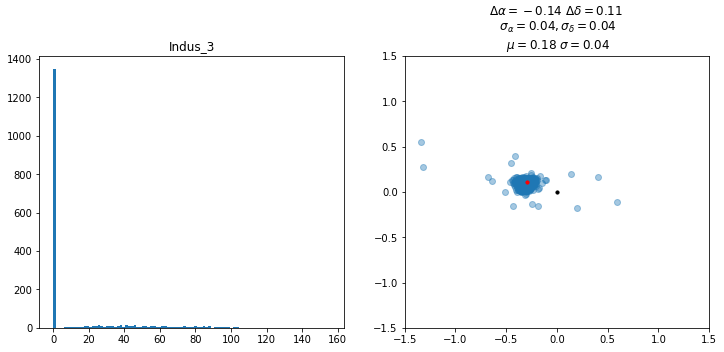

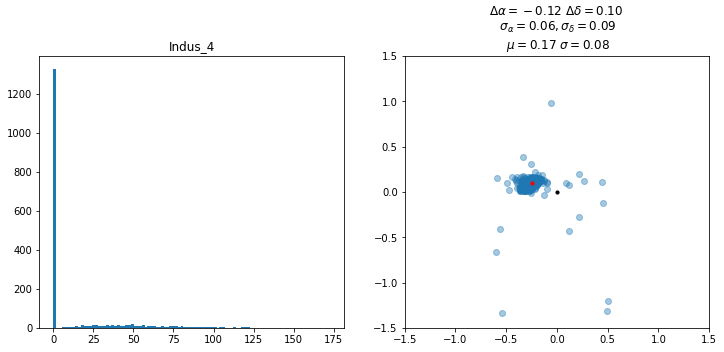

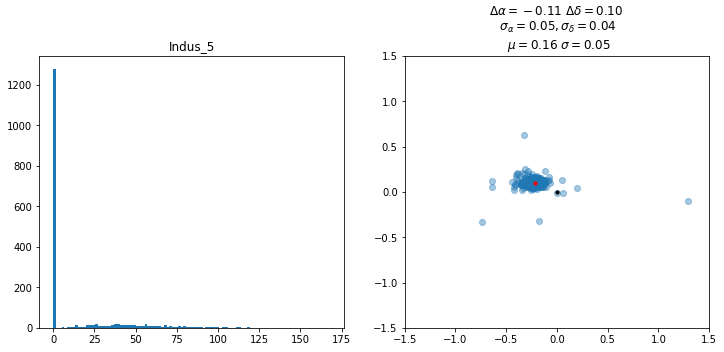

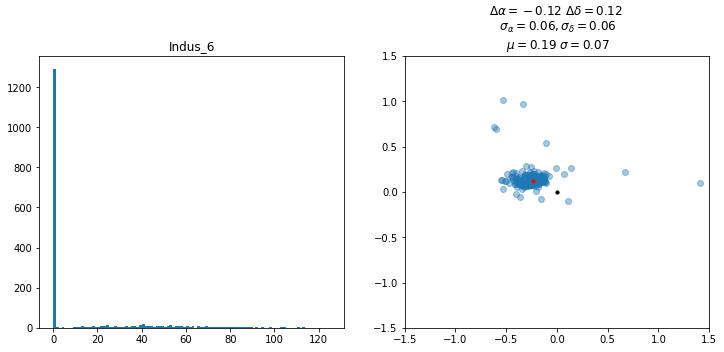

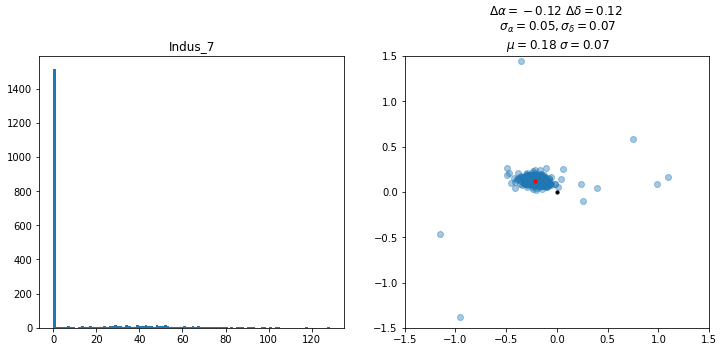

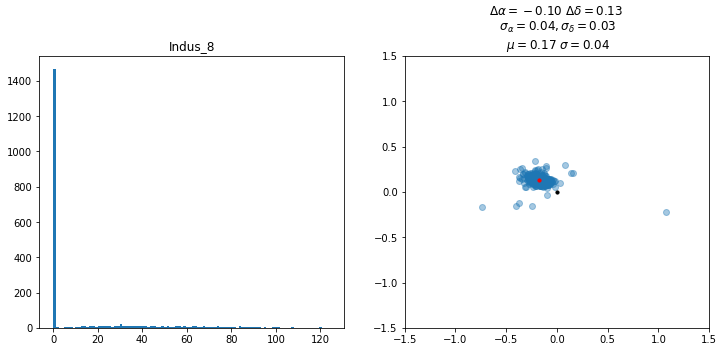

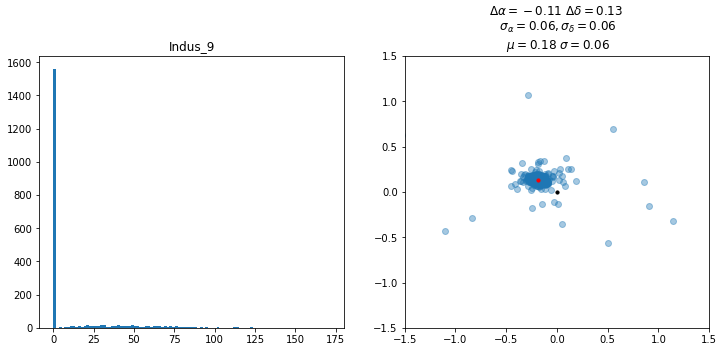

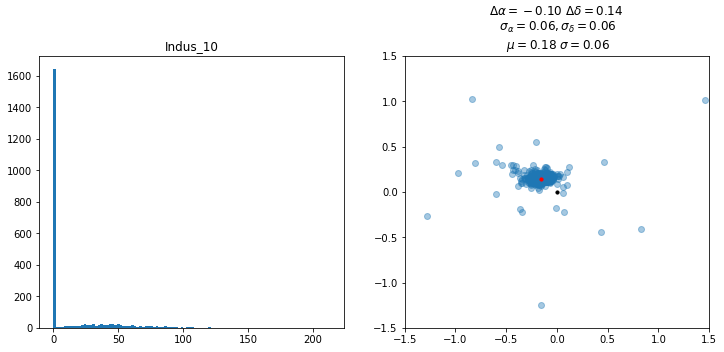

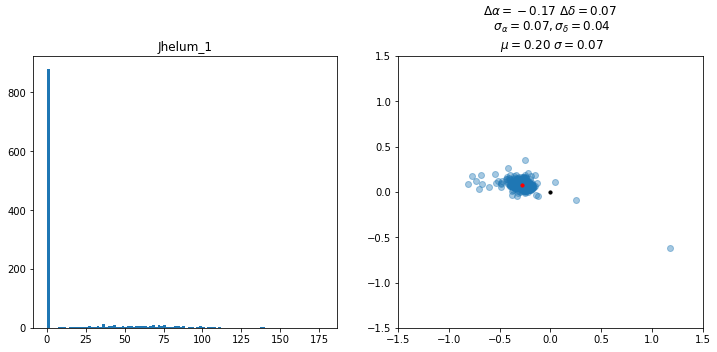

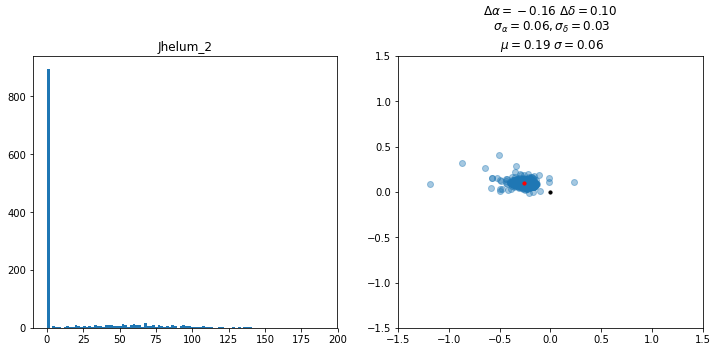

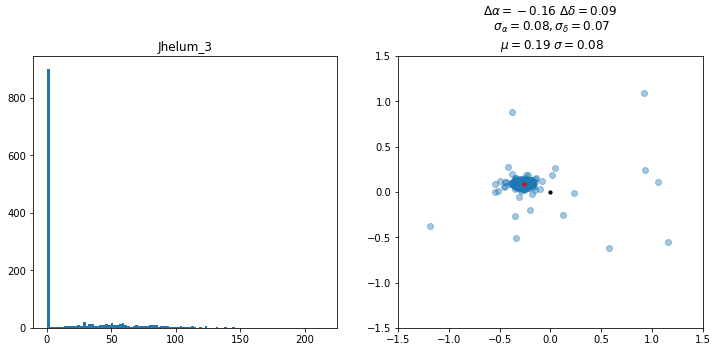

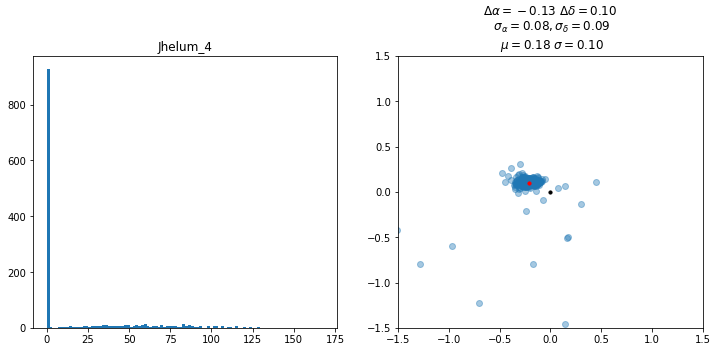

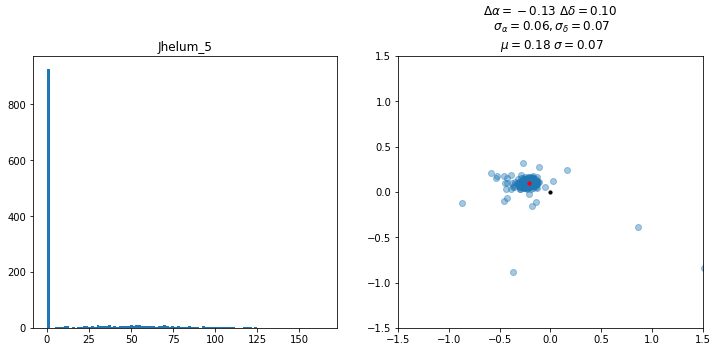

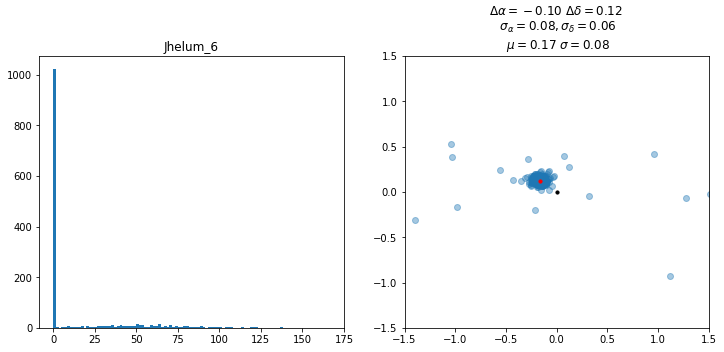

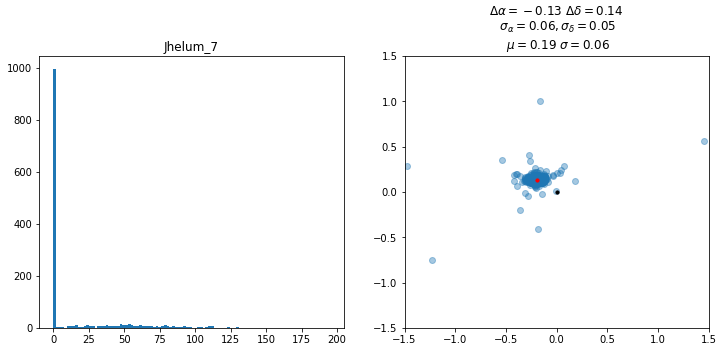

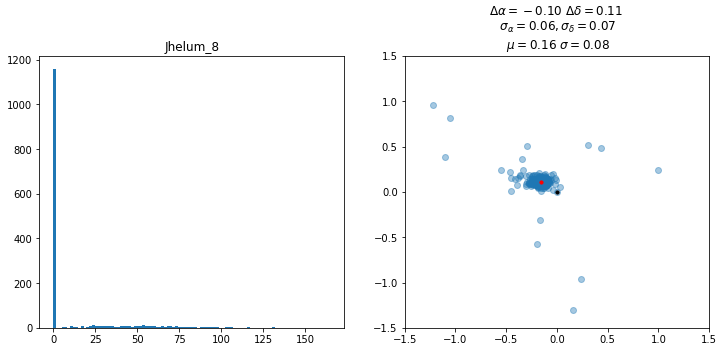

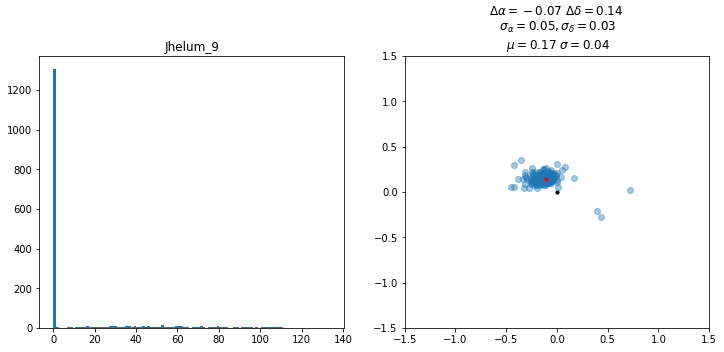

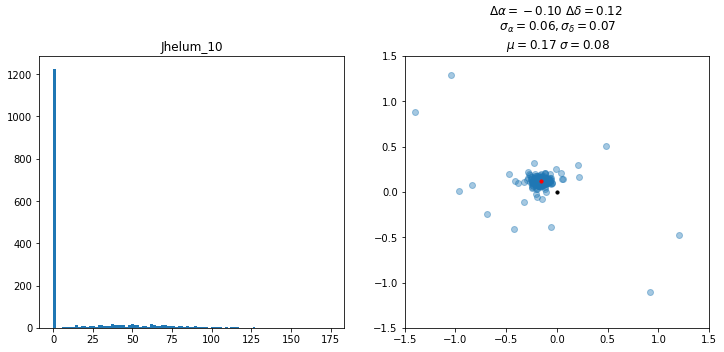

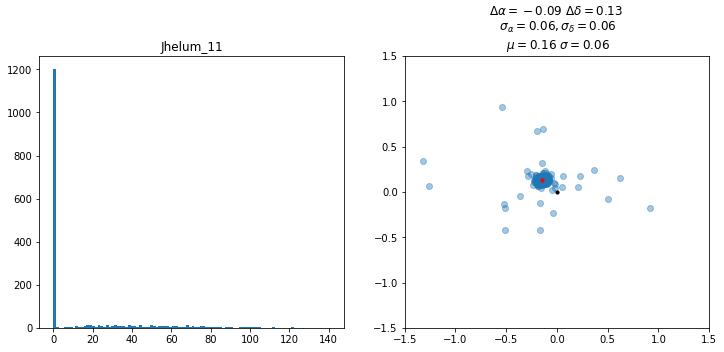

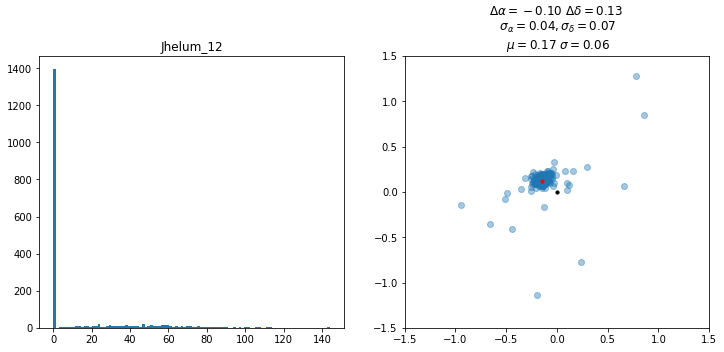

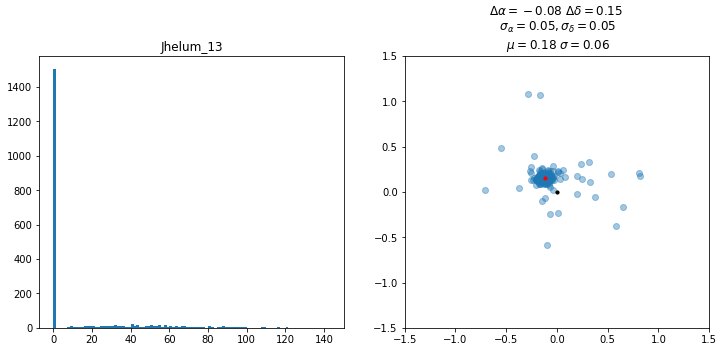

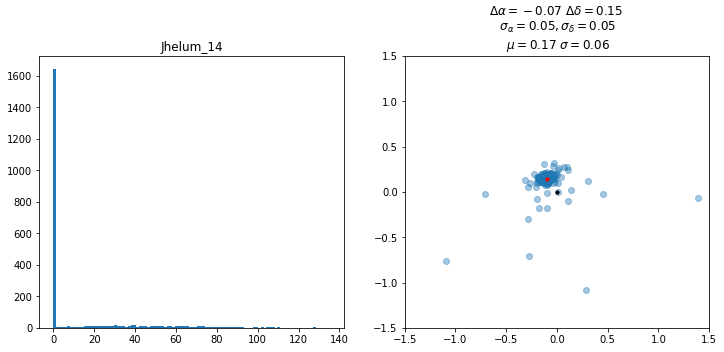

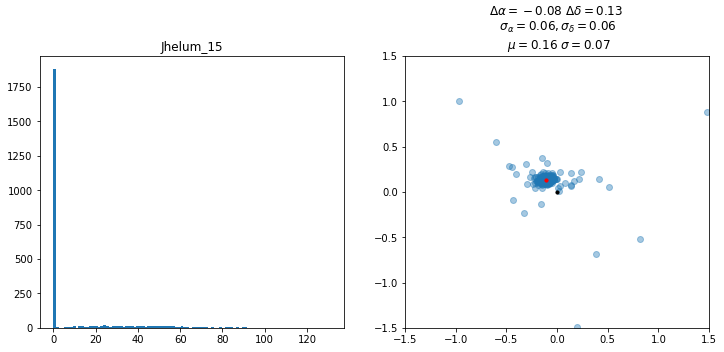

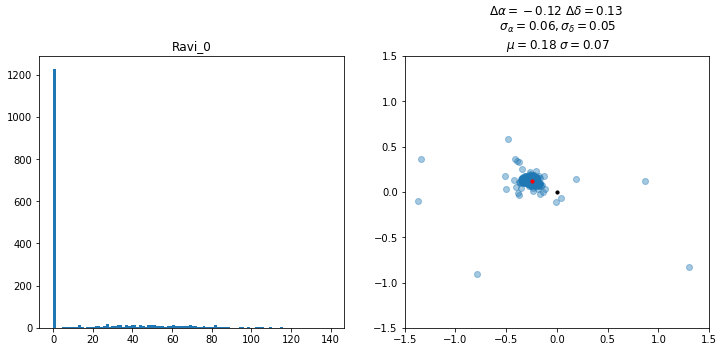

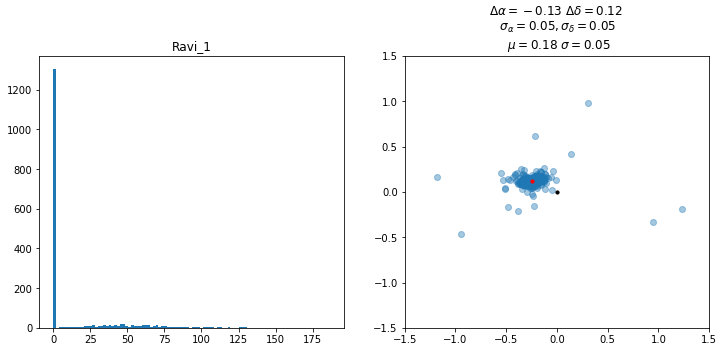

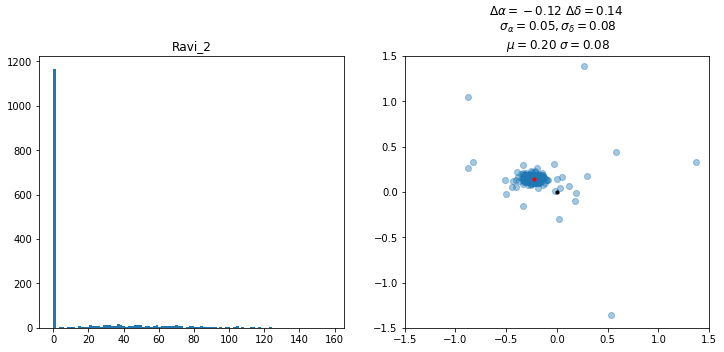

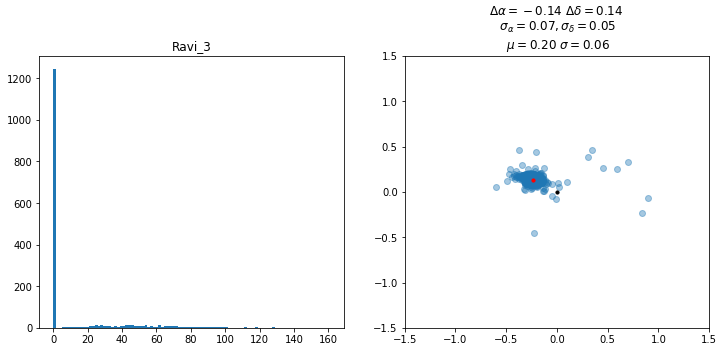

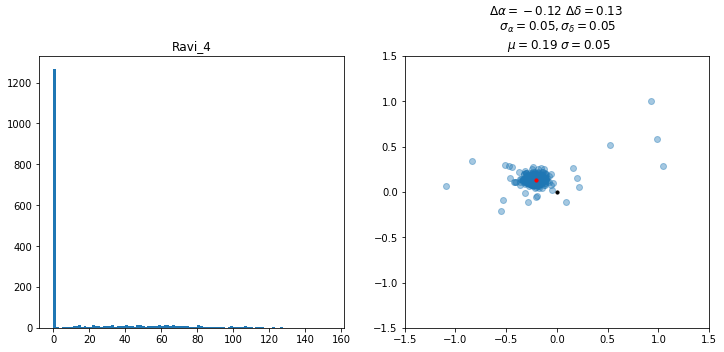

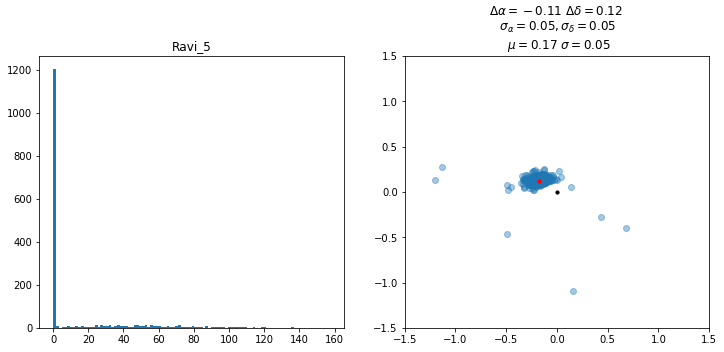

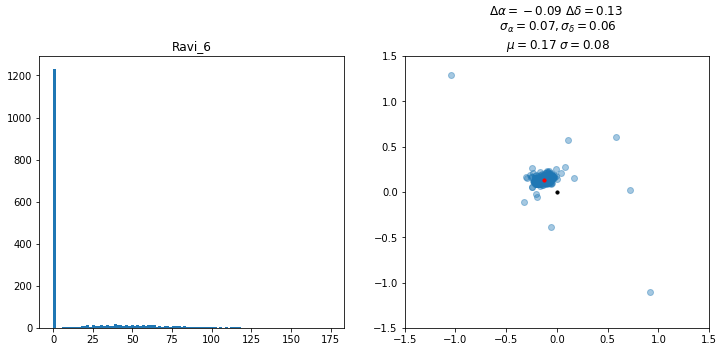

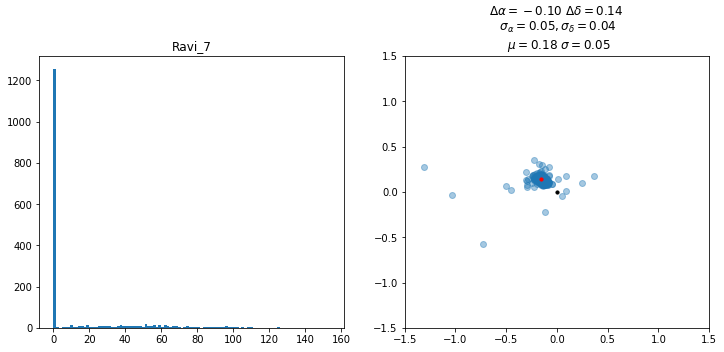

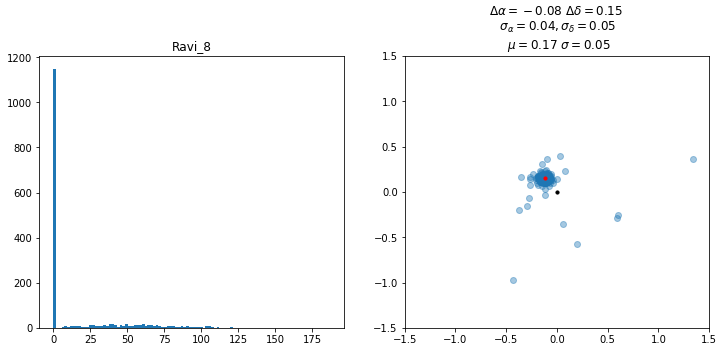

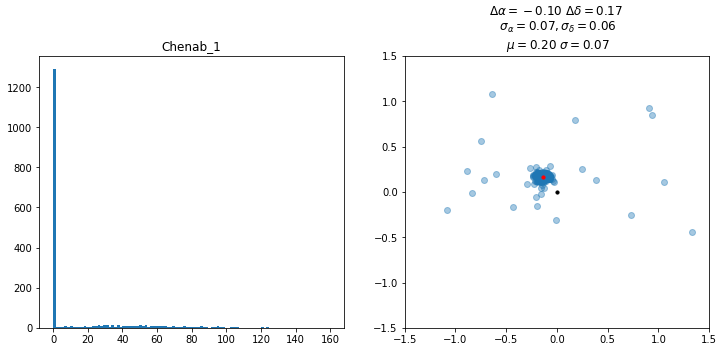

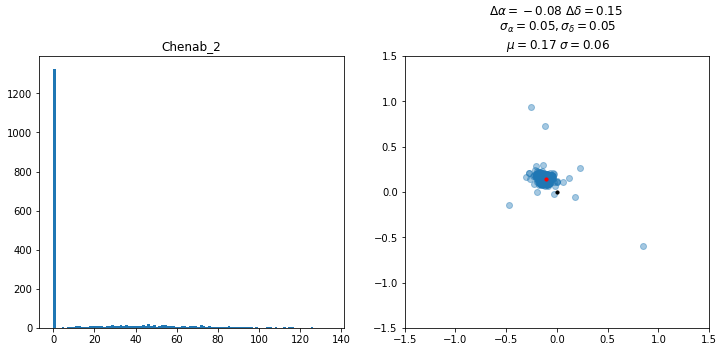

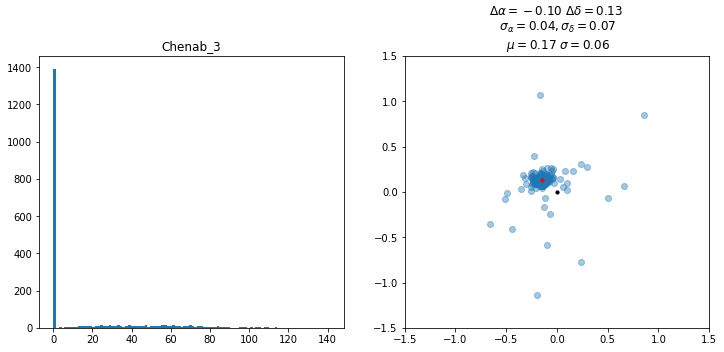

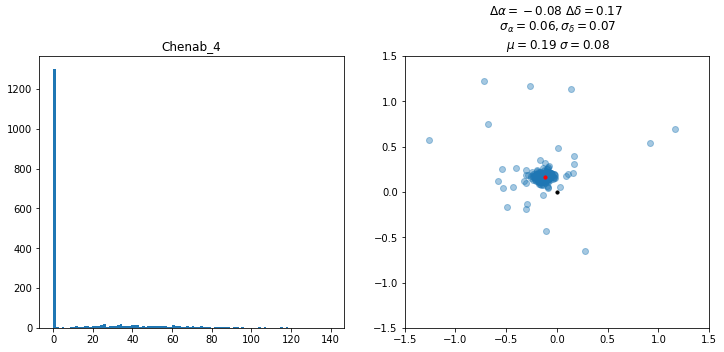

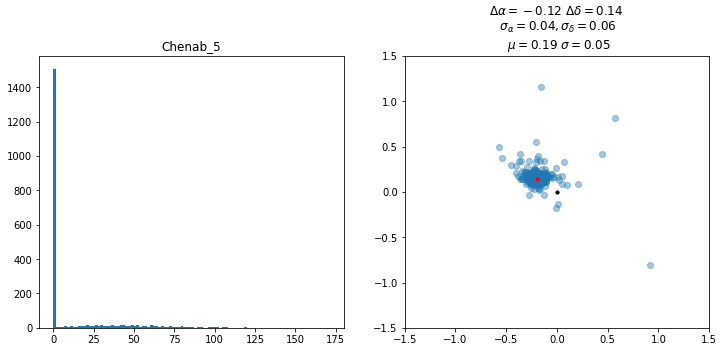

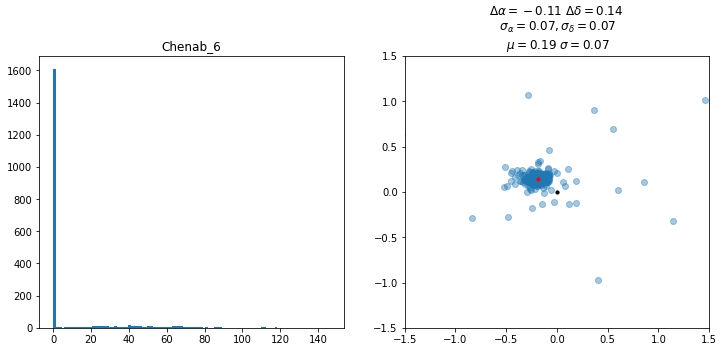

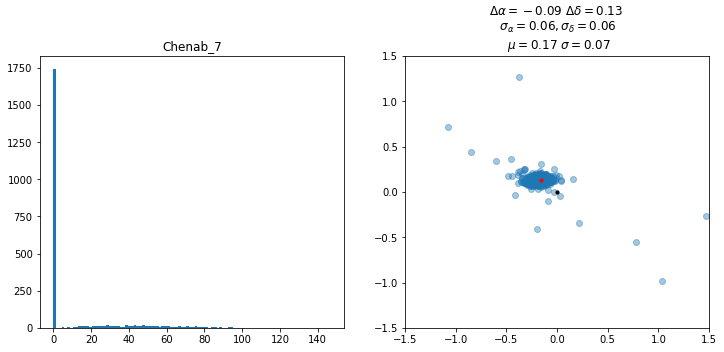

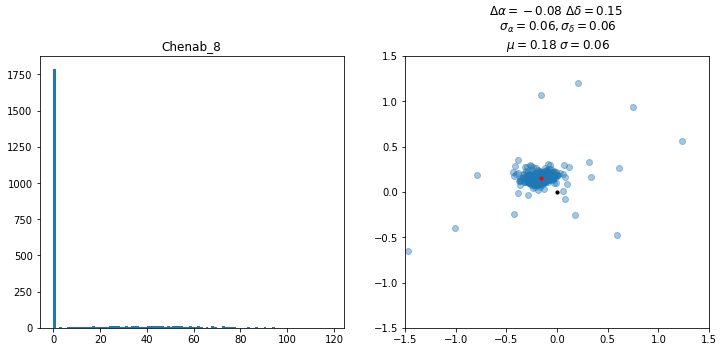

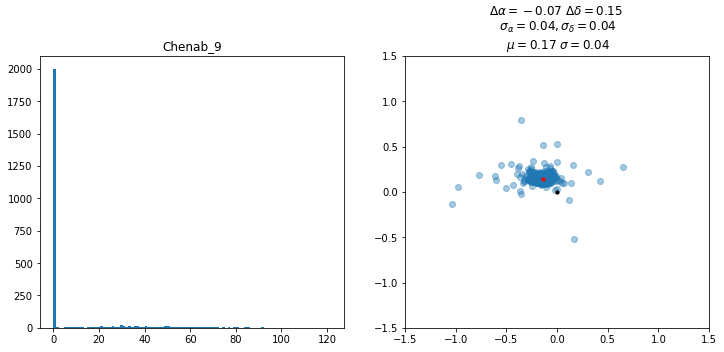

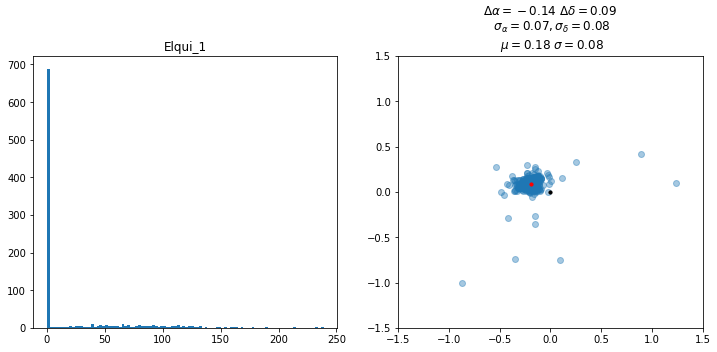

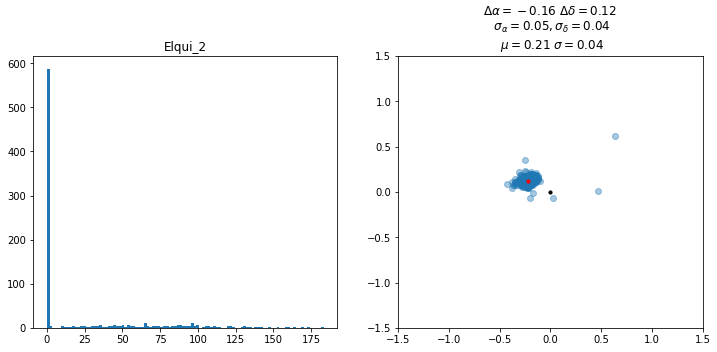

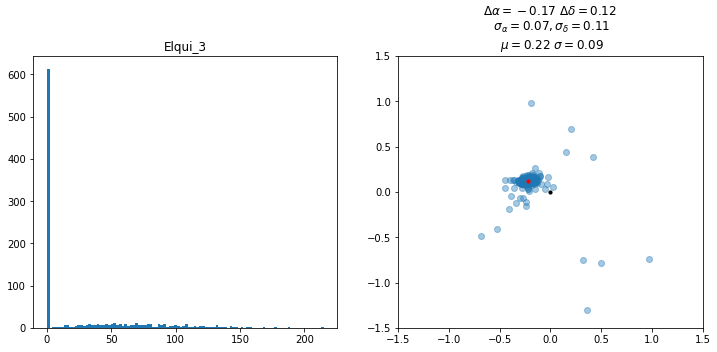

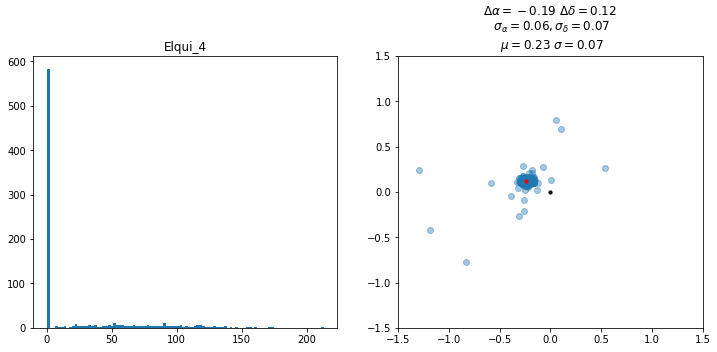

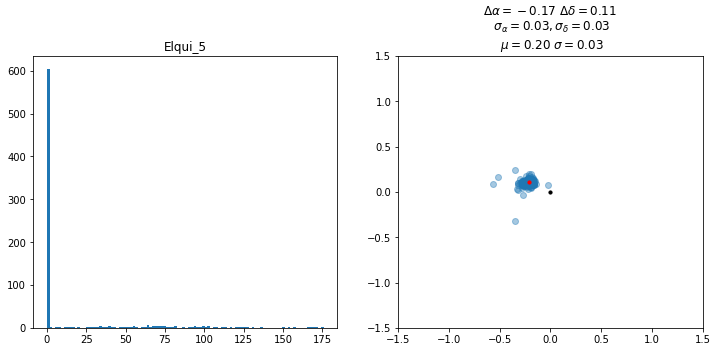

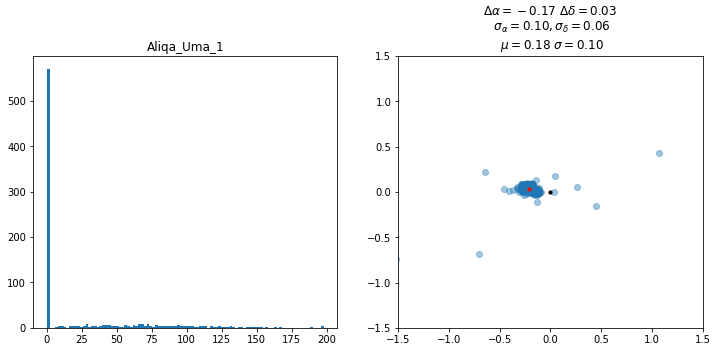

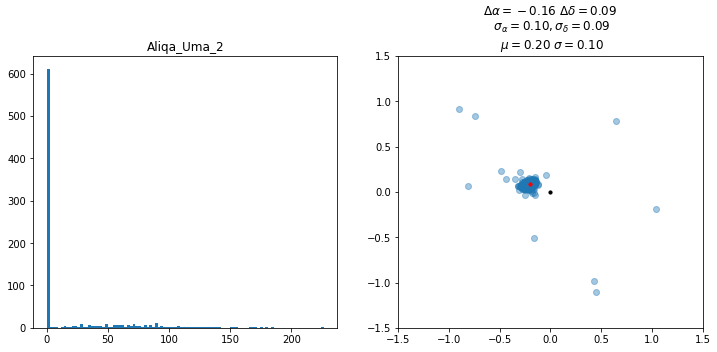

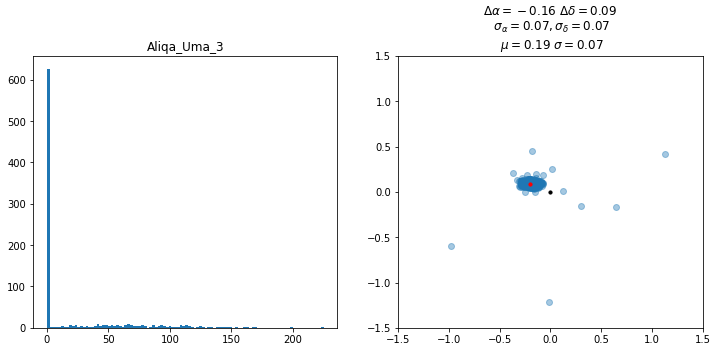

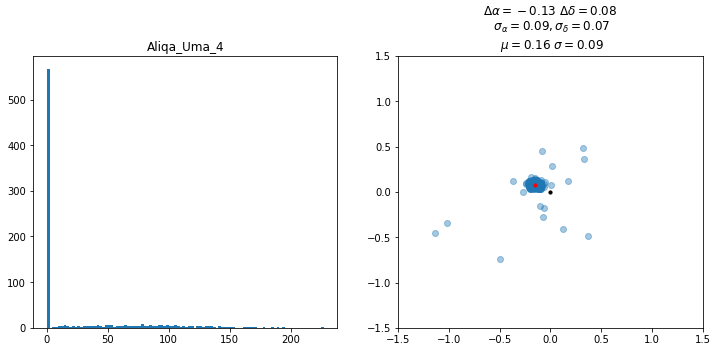

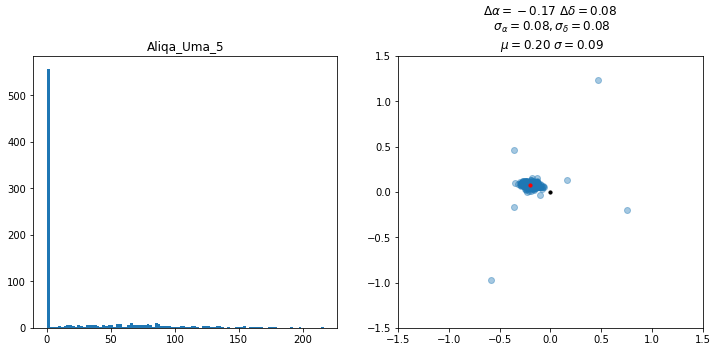

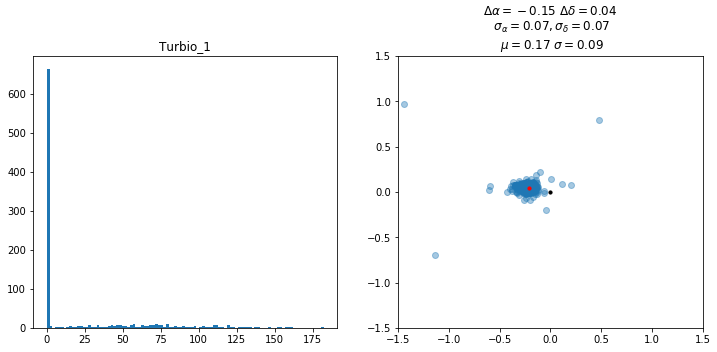

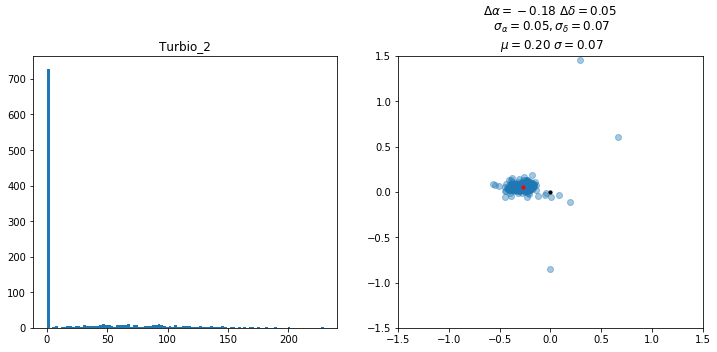

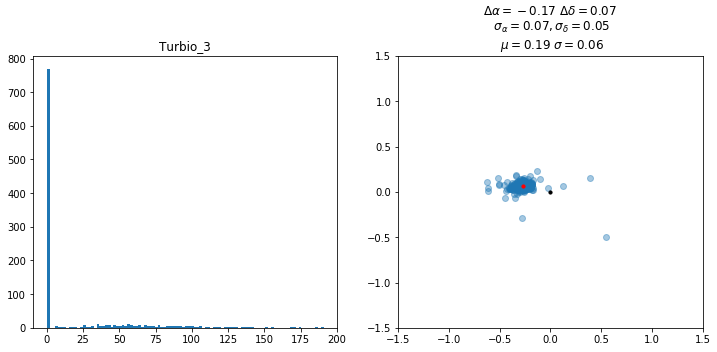

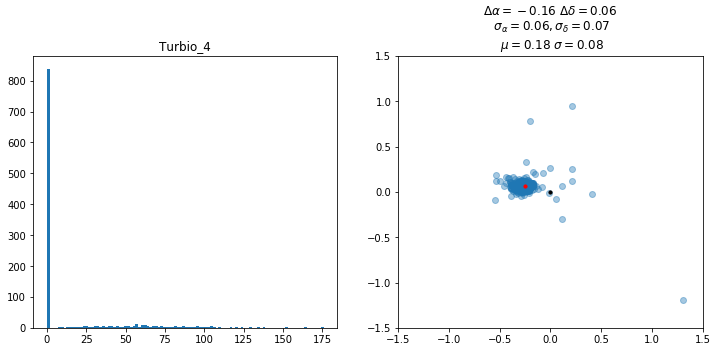

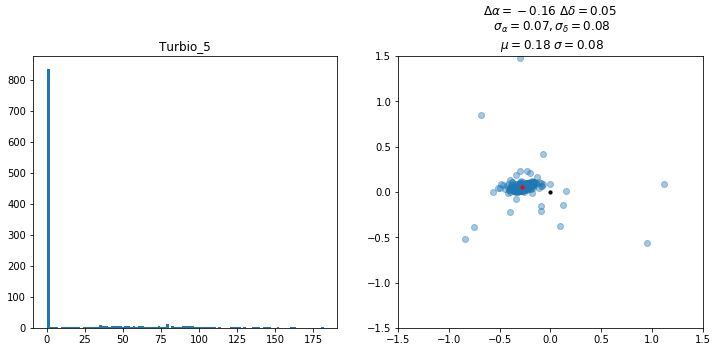

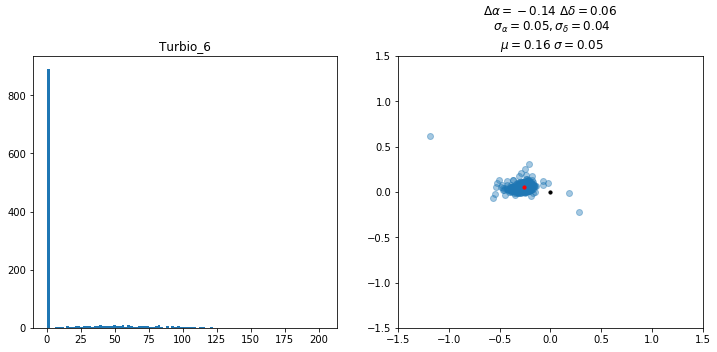

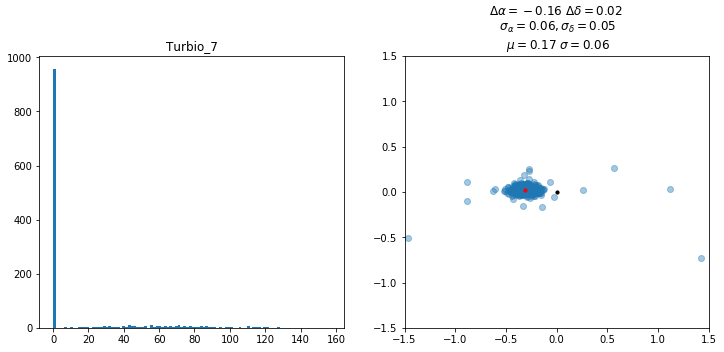

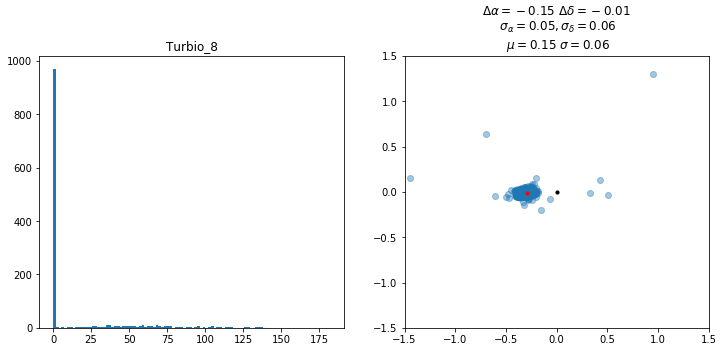

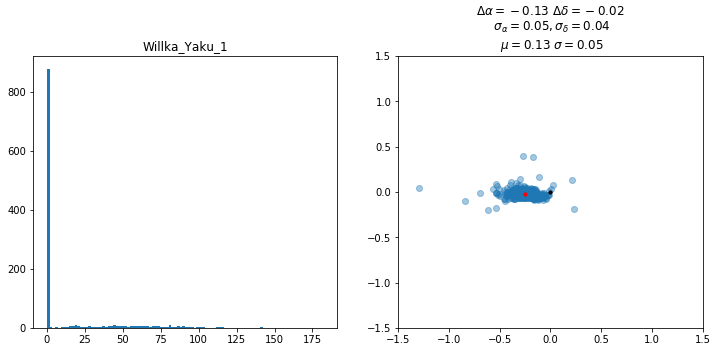

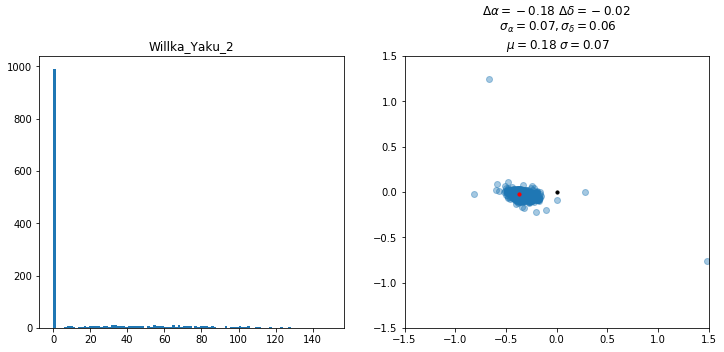

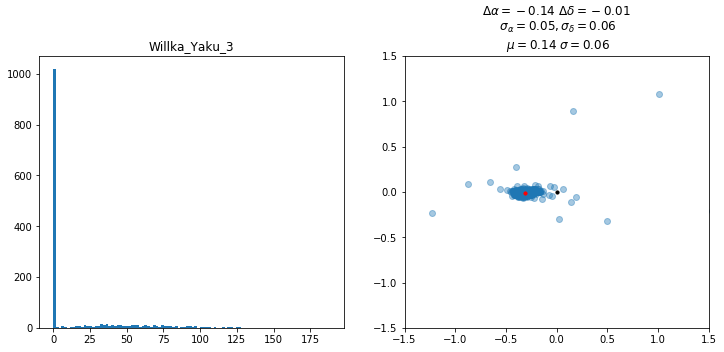

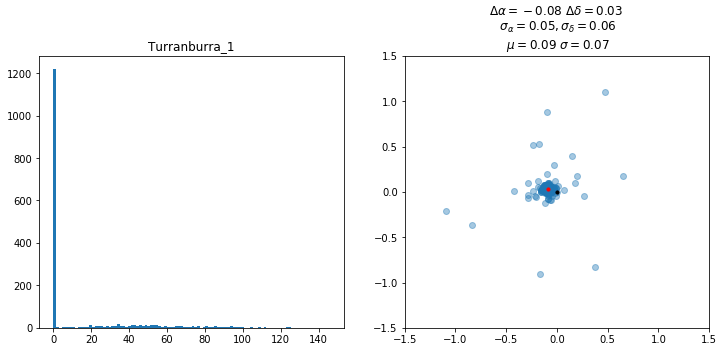

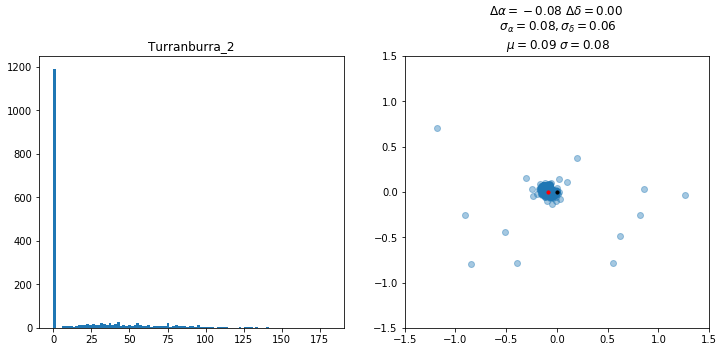

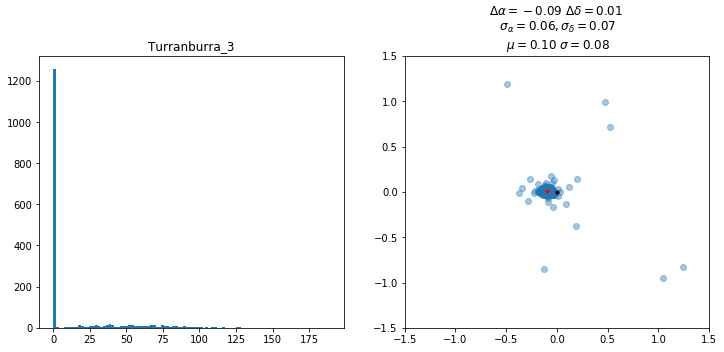

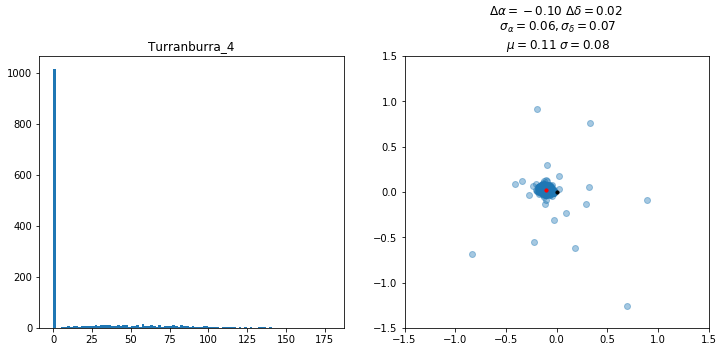

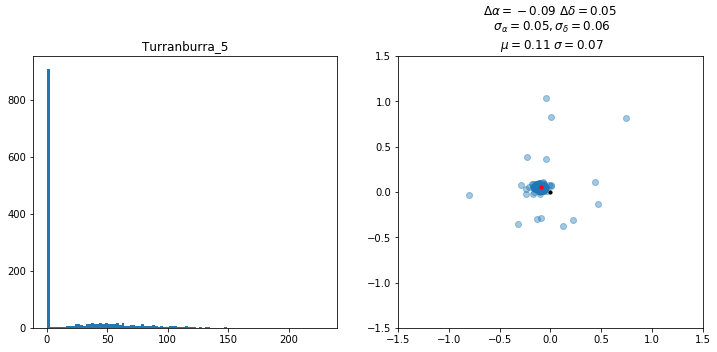

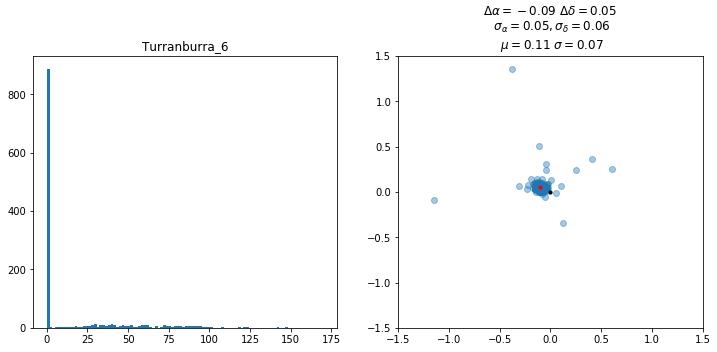

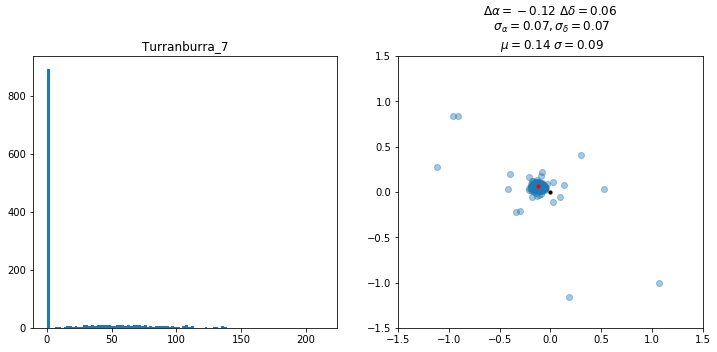

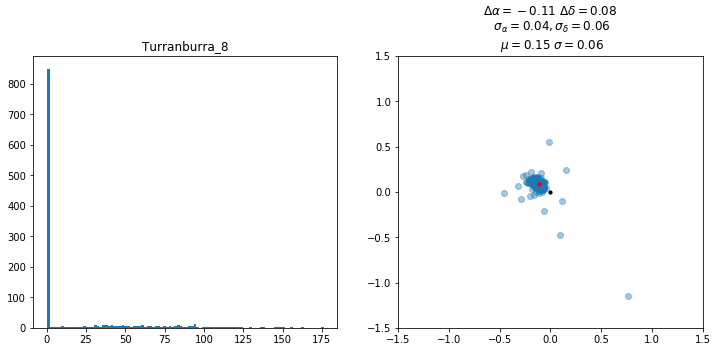

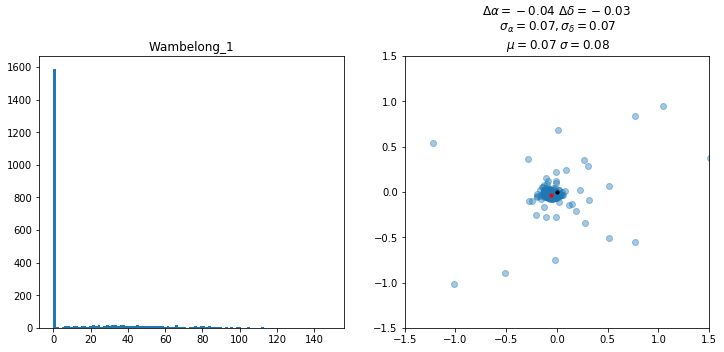

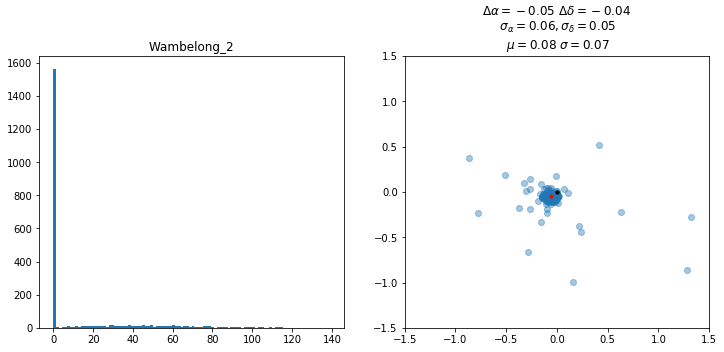

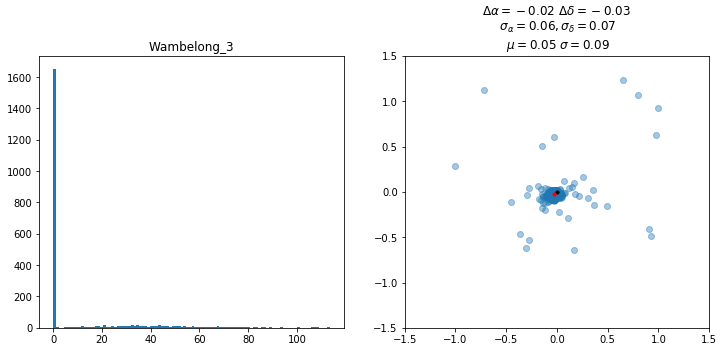

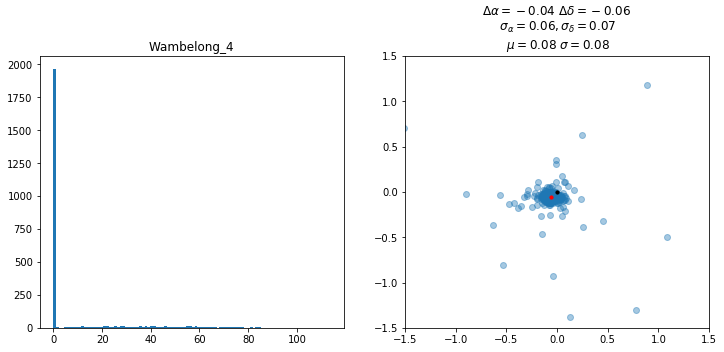

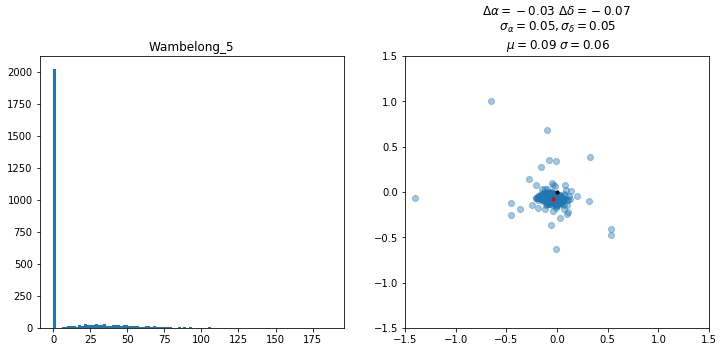

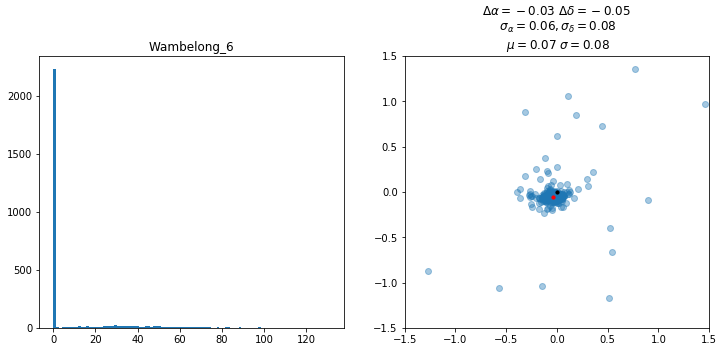

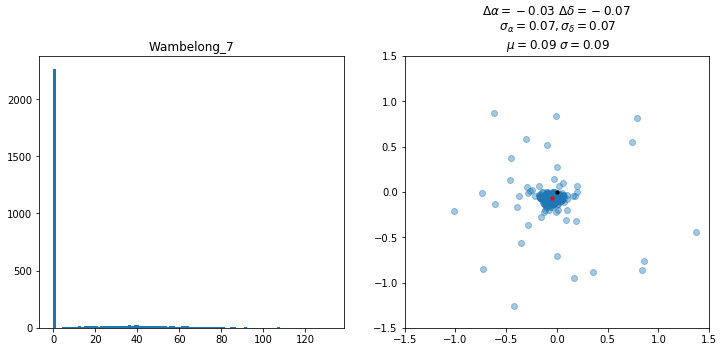

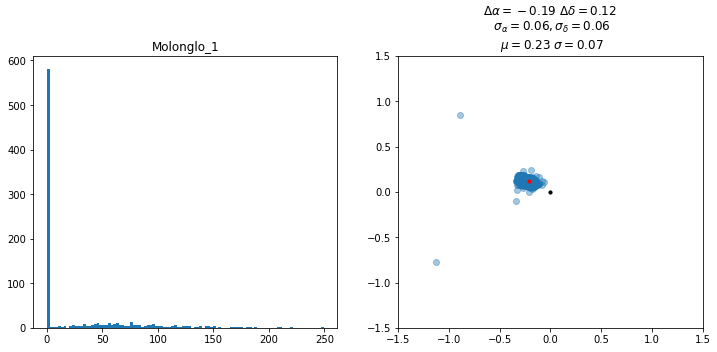

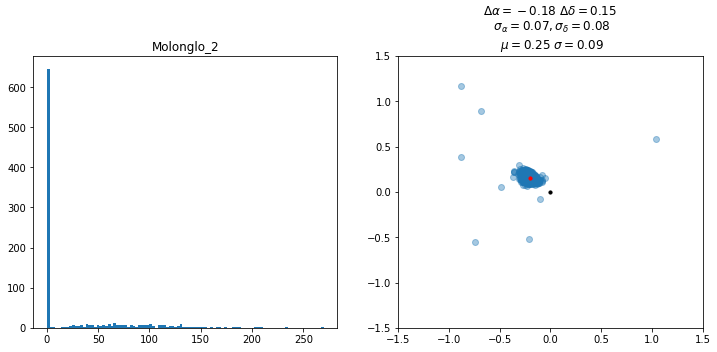

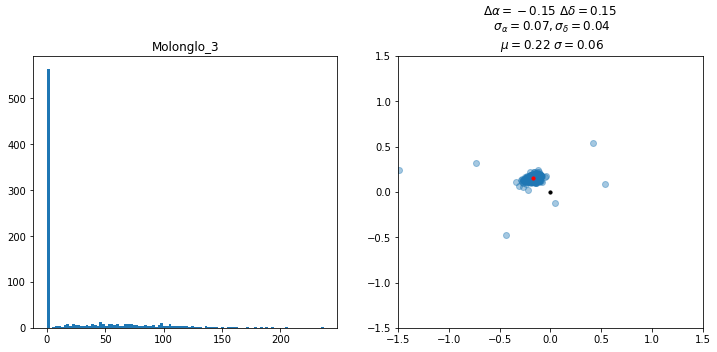

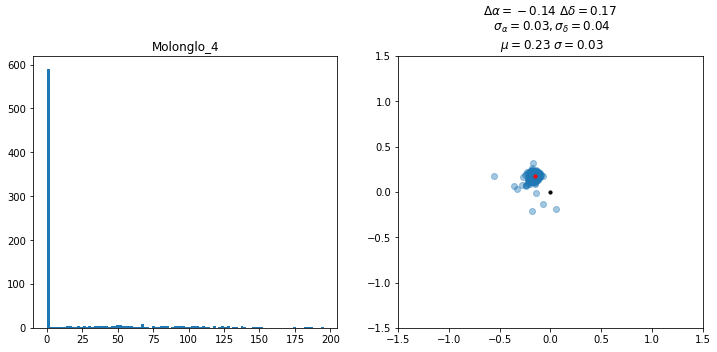

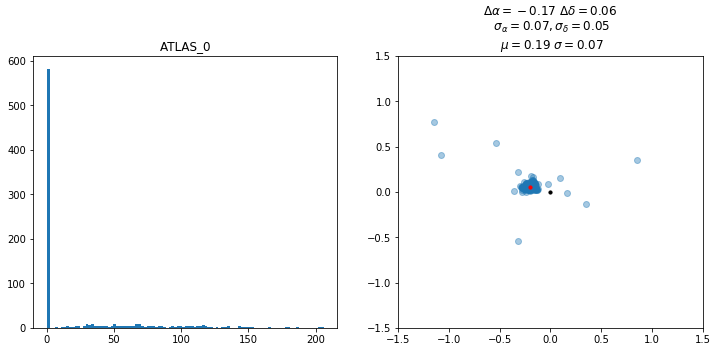

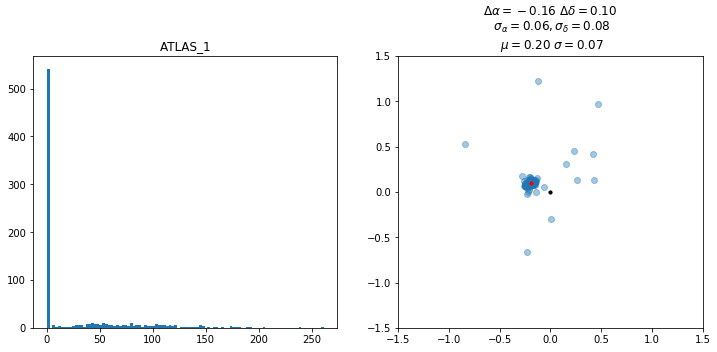

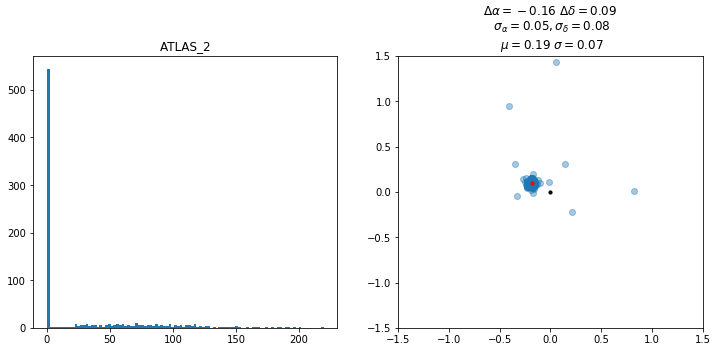

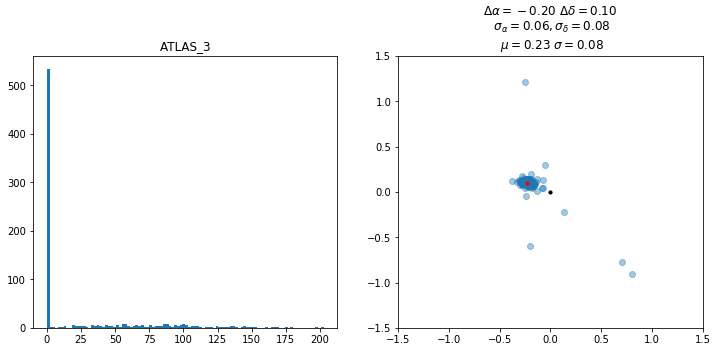

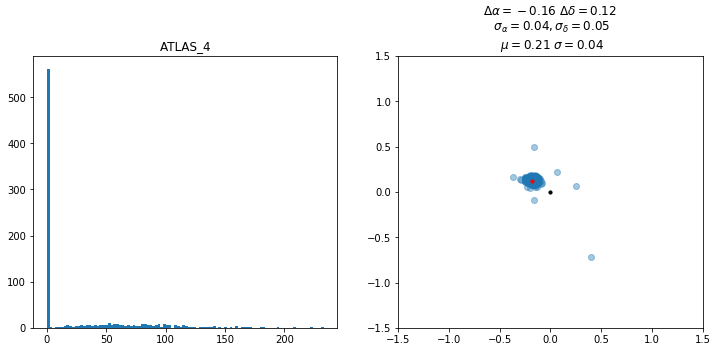

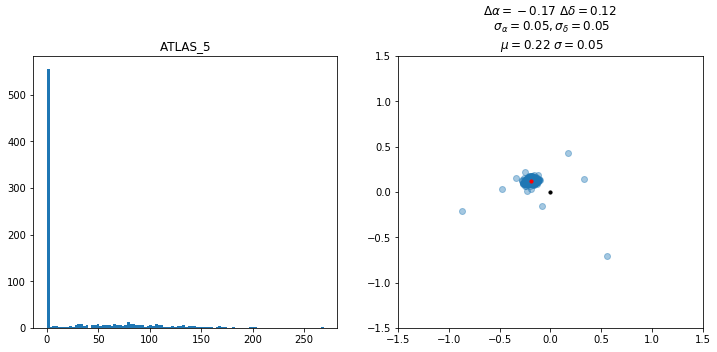

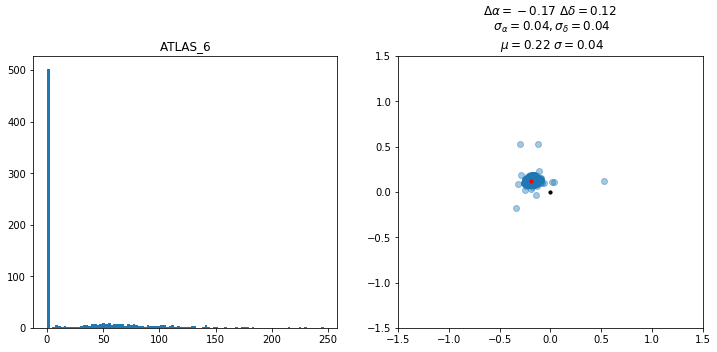

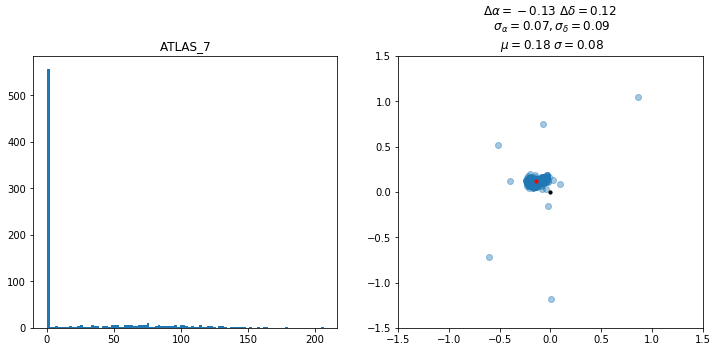

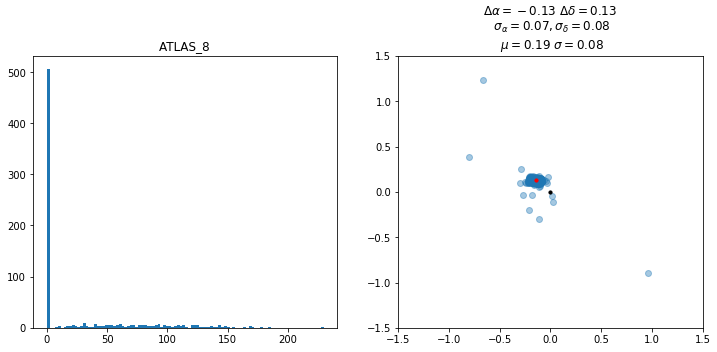

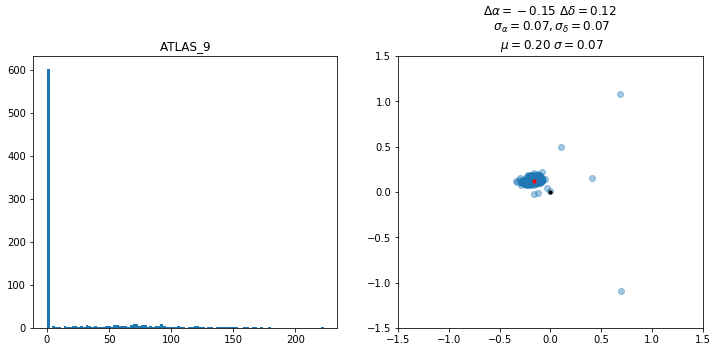

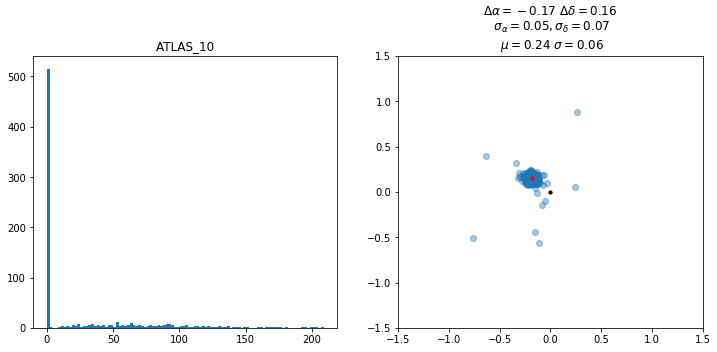

In [23]:
offset_dct = {}
for field in tqdm.tqdm_notebook(fields):
    fnm = field['field_id']
    fn = 'external_catalogs/astrometric/{}_gaia.ecsv'.format(fnm)
    
    if os.path.isfile(fn):
        offset_dct[fnm] = offsets = get_offsets(fnm, fn, doplot=True, biweight=True)
        print('Offsets for', fnm, 'are:', offsets)
    else:
        print('No astrometric catalog', fn,' found')

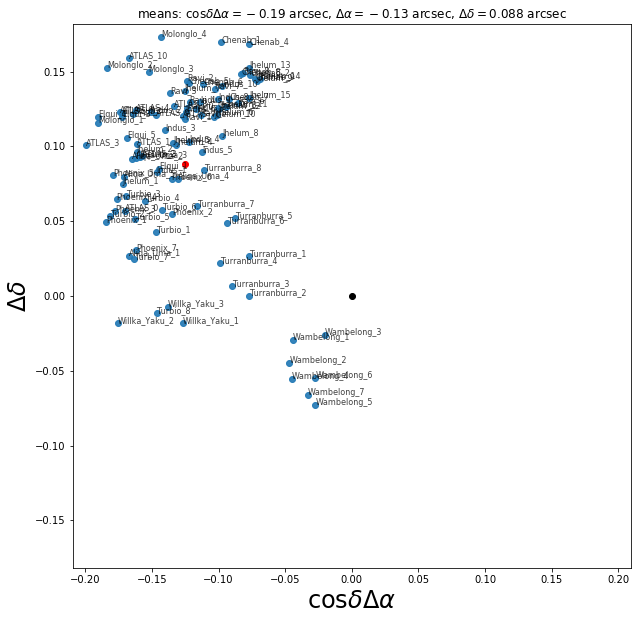

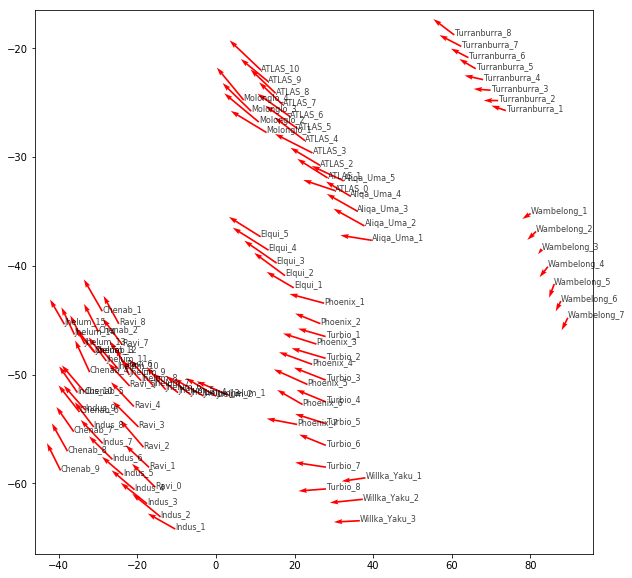

In [86]:
nms = []
ras = []
decs = []
raoffs = []
decoffs = []
otherraoffs = []
for fnm, offsets in offset_dct.items():
    fi = saga_field_catalog.load_single(fnm)
    ras.append(fi['RA'])
    decs.append(fi['Dec'])
    raoffs.append(offsets[1])
    otherraoffs.append(offsets[0])
    decoffs.append(offsets[2])
    nms.append(fnm)
ras = Angle(ras, u.deg).wrap_at(180*u.deg)
otherraoffs = Angle(otherraoffs, u.deg).wrap_at(180*u.deg)
decs = u.Quantity(decs, u.deg)
raoffs = u.Quantity(raoffs)
decoffs = u.Quantity(decoffs)

meanra = np.mean(raoffs)
meanotherraoff = np.mean(otherraoffs).to(u.arcsec)
meandec = np.mean(decoffs)

plt.figure(figsize=(10, 10))

for x, y, t in zip(raoffs, decoffs, nms):
    plt.text(x.value, y.value, t, alpha=.75, fontsize=8)
    
plt.scatter(raoffs.value, decoffs.value, alpha=.9)
plt.scatter([meanra.value], [meandec.value], c='r')
plt.scatter([0], [0], c='k')
xmx = np.max(np.abs(raoffs.value))*1.05
ymx = np.max(np.abs(decoffs.value))*1.05
plt.xlim(-xmx, xmx)
plt.ylim(-ymx, ymx)
plt.title(r'means: $\cos \delta \Delta \alpha = {2.value:.2}$ {2.unit}, $\Delta \alpha = {0.value:.2}$ {0.unit}, $\Delta \delta = {1.value:.2}$ {1.unit}'.format(meanra, meandec, meanotherraoff))
plt.xlabel(r'$\cos{\delta} \Delta \alpha$', fontsize=24)
plt.ylabel(r'$\Delta \delta$', fontsize=24)


plt.figure(figsize=(10, 10))
for x, y, t in zip(ras, decs, nms):
    plt.text(x.value, y.value, t, alpha=.75, fontsize=8)
plt.quiver(ras.value, decs.value, raoffs.value, decoffs.value, color='r', width=.003);

In [38]:
!subl ting_field_offsets.ecsv

In [25]:
astrometry_offset_table = Table()
astrometry_offset_table['field_name'] = list(offset_dct.keys())
astrometry_offset_table['deltara_des_minus_gaia'] = u.Quantity([meanra for meanra, meanracosdec, meandec in offset_dct.values()])
astrometry_offset_table['deltara_cosdec_des_minus_gaia'] = u.Quantity([meanracosdec for meanra, meanracosdec, meandec in offset_dct.values()])
astrometry_offset_table['deltadec_des_minus_gaia'] = u.Quantity([meandec for meanra, meanracosdec, meandec in offset_dct.values()])
astrometry_offset_table.write('ting_field_offsets.ecsv', format='ascii.ecsv', overwrite=True)
astrometry_offset_table

<Table length=101>
field_name deltara_des_minus_gaia ... deltadec_des_minus_gaia
                   arcsec         ...          arcsec        
  str13           float64         ...         float64        
---------- ---------------------- ... -----------------------
 Phoenix_1    -0.2534681234875746 ...     0.04928130964980694
 Phoenix_2   -0.19106930073370287 ...     0.05450961969198831
 Phoenix_3   -0.26176879451652246 ...     0.05653023227604625
 Phoenix_4    -0.2690338329344234 ...     0.06490215224382968
 Phoenix_5      -0.28473702137923 ...      0.0808209705351218
 Phoenix_6   -0.22345142405597596 ...      0.0781159982027361
 Phoenix_7    -0.2792392661616715 ...    0.030701437420336205
   Indus_1    -0.3368617998099156 ...      0.0828139687639578
   Indus_2    -0.3324258467979234 ...     0.12291888341384916
       ...                    ... ...                     ...
   ATLAS_1   -0.19029515677361994 ...     0.10134370628025523
   ATLAS_2   -0.18326283657245698 ...     0.09379494246357424
   ATLAS_3    -0.2296011413113545 ...     0.10113344916507062
   ATLAS_4   -0.18414420425646535 ...     0.12408306463653729
   ATLAS_5    -0.1942440956288546 ...     0.12238058443430164
   ATLAS_6   -0.19421573895007455 ...     0.12280261558003792
   ATLAS_7   -0.13990920748884947 ...     0.12043249782362012
   ATLAS_8   -0.14615815259848886 ...     0.12684574110868152
   ATLAS_9   -0.15969333090111298 ...     0.12068922399102847
  ATLAS_10   -0.18028548251746437 ...       0.158755839499717

# Cross-check with DES fits

These astrometry offset polynomial fits were created by Alex D-W and William Wester by way of Ting - these are parametric fits to the offsets across the fields. Should be consistent with the fit above (Although might be a sign offset?):

In [30]:
def cel2gal(ra, dec):
    # I'm guessing this was from elsewhere, perhaps the C or IDL routine, but should be the same
    from astropy.coordinates import ICRS, Galactic
    gal = ICRS(ra*u.deg, dec*u.deg).transform_to(Galactic)
    return gal.l.deg, gal.b.deg
    
def delra(ra,dec):
    # RA transformation
    p0 = 0.38808
    p1 = 1.90683E-02
    p2 = 1.15439E-04
    gall, galb = cel2gal(ra,dec)
    ra_cor = 0.375 * (p0 + p1*galb + p2*galb**2)
    return (ra_cor/3600.)

def deldec(ra,dec):
    ra_offset = 30.
    thetad = np.radians(45.)
    p0 = 0.15279
    p1 = -6.63167E-03
    p2 = -9.77632E-05
    alphaprime = ra - 360*(ra > 180)
    alphaprime = alphaprime * np.cos(np.radians(dec)) - 30.
    deltaprime = dec + 30.
    r8temp1 = alphaprime*np.cos(thetad) - deltaprime*np.sin(thetad)
    r8temp2 = alphaprime*np.sin(thetad) + deltaprime*np.cos(thetad)
    alphaprime = r8temp1
    deltaprime = r8temp2
    #dec_cor = 0.8 * (p0 + p1*alphaprime + p2*alphaprime**2)
    dec_cor = 0.55 * (p0 + p1*alphaprime + p2*alphaprime**2)
    return (dec_cor / 3600.)

In [90]:
fnms = []
dra_des = []
ddec_des =[]
meanras = []
meandecs = []
ras = []
decs = []

for field in fields:
    ras.append(field['RA'])
    decs.append(field['Dec'])
    dra_des.append(delra(field['RA'], field['Dec']))
    ddec_des.append(deldec(field['RA'], field['Dec']))
    
    fnm = field['field_id']
    fnms.append(fnm)
    meanra, meanracosdec, meandec = offset_dct[fnm]
    meanras.append(meanracosdec)
    meandecs.append(meandec)
    
comparison_table = Table(data=[fnms, 
                               u.Quantity(dra_des, u.deg).to(u.arcsec), u.Quantity(meanras), 
                               u.Quantity(ddec_des, u.deg).to(u.arcsec), u.Quantity(meandecs),
                               u.Quantity(ras, u.deg), u.Quantity(decs, u.deg)], 
                         names=['field_name', 'DES_dra', 'this_dra', 'DES_ddec', 'this_ddec', 'ra','dec'])
comparison_table

<Table length=101>
field_name       DES_dra              this_dra       ...     ra        dec    
                  arcsec               arcsec        ...    deg        deg    
  str13          float64              float64        ...  float64    float64  
---------- -------------------- -------------------- ... ---------- ----------
 Phoenix_1 -0.14271642640921167 -0.18422770274909567 ...  27.522008 -43.435281
 Phoenix_2 -0.14149760432743091  -0.1345801829719594 ...  26.574582 -45.317191
 Phoenix_3  -0.1400223638602593  -0.1778810170822331 ...  25.562194 -47.190731
 Phoenix_4 -0.13827892984601212 -0.17650497365965184 ...  24.475886 -49.054701
 Phoenix_5 -0.13625701782215624 -0.17937577511975156 ...  23.305174 -50.907683
 Phoenix_6 -0.13394785984593124 -0.13521503357102038 ...  22.037714  -52.74799
 Phoenix_7 -0.13134410017313666  -0.1620128656962481 ...  20.658903 -54.573598
   Indus_1 -0.10393683923518246 -0.14653740647372318 ... 349.676816 -64.191757
   Indus_2 -0.10374801970608591 -0.15060137307686386 ... 345.943921 -63.072259
       ...                  ...                  ... ...        ...        ...
   ATLAS_1   -0.147679575606476 -0.16127093759488506 ...  28.405246  -31.92474
   ATLAS_2 -0.14865545142188852 -0.15752290421566958 ...  26.478875 -30.769164
   ATLAS_3 -0.14931640947969319 -0.19939101204120147 ...  24.568376 -29.630455
   ATLAS_4  -0.1496740536846903 -0.16174601604642883 ...  22.671632 -28.507156
   ATLAS_5   -0.149750294504322 -0.17222491116715924 ...  20.786727 -27.397962
   ATLAS_6  -0.1495927788137862 -0.17403567091691297 ...   18.91193 -26.301707
   ATLAS_7  -0.1493139350013068  -0.1265922150124265 ...   17.04559 -25.217464
   ATLAS_8 -0.14914311663739938  -0.1333730165392692 ...  15.186315 -24.144268
   ATLAS_9 -0.14927295899900192 -0.14679667559814547 ...  13.332881 -23.081229
  ATLAS_10 -0.14955424646476126  -0.1672147204594962 ...  11.484042 -22.027756

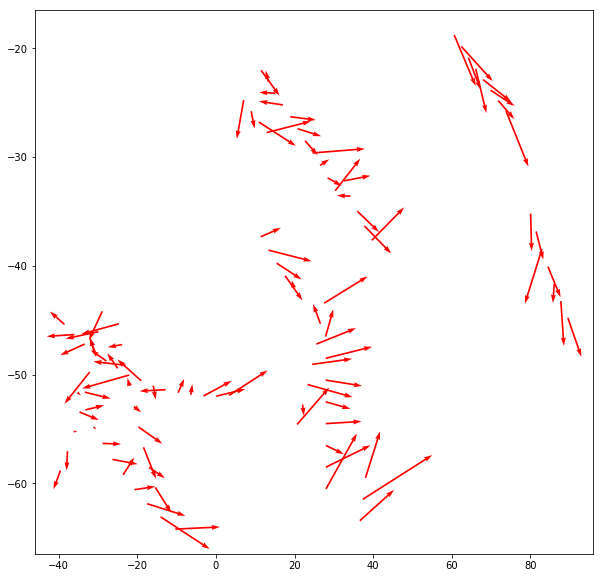

In [91]:
plt.figure(figsize=(10, 10))
plt.quiver(Angle(comparison_table['ra']).wrap_at(180*u.deg).deg, comparison_table['dec'],
           comparison_table['DES_dra']-comparison_table['this_dra'],
           comparison_table['DES_ddec']-comparison_table['this_ddec'],
           color='red',  width=.003)

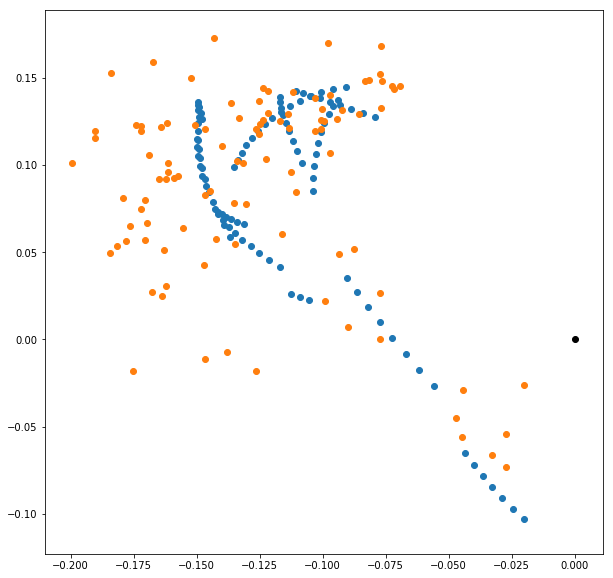

In [92]:
plt.figure(figsize=(10, 10))
plt.scatter(comparison_table['DES_dra'], comparison_table['DES_ddec'])
plt.scatter(comparison_table['this_dra'], comparison_table['this_ddec'])
plt.scatter([0], [0], color='k')

In [96]:
stats.biweight_location?

Signature: stats.biweight_location(data, c=6.0, M=None, axis=None)
Docstring:
Compute the biweight location.

The biweight location is a robust statistic for determining the
central location of a distribution.  It is given by:

.. math::

    \zeta_{biloc}= M + \frac{\Sigma_{|u_i|<1} \ (x_i - M) (1 - u_i^2)^2}
        {\Sigma_{|u_i|<1} \ (1 - u_i^2)^2}

where :math:`x` is the input data, :math:`M` is the sample median
(or the input initial location guess) and :math:`u_i` is given by:

.. math::

    u_{i} = \frac{(x_i - M)}{c * MAD}

where :math:`c` is the tuning constant and :math:`MAD` is the
`median absolute deviation
<https://en.wikipedia.org/wiki/Median_absolute_deviation>`_.  The
biweight location tuning constant ``c`` is typically 6.0 (the
default).

Parameters
----------
data : array-like
    Input array or object that can be converted to an array.
c : float, optional
    Tuning constant for the biweight estimator (default = 6.0).
M : float or array-like, optional
    Initial g

NOTE: This makes it pretty clear the quoted delra from DES is the delta-ra *cos dec*, not just delta-ra

## Check that output file is applied with the correct sign convention 

Done as a 2nd-person cross-check to make sure we got the sign the right way

In [192]:
pho1_corrected = Table.read('field_Phoenix_1_stars.csv') # from Marla

# to match the DES tables 
pho1_corrected['RA'].name = 'ra'
pho1_corrected['DEC'].name = 'dec'

#pho1_corrected['ra'] -= astrometry_offset_table['deltara_des_minus_gaia'].to(u.deg).value[0]
#pho1_corrected['dec'] -= astrometry_offset_table['deltadec_des_minus_gaia'].to(u.deg).value[0]

(<Angle 0.00458696 arcsec>,
 <Angle 0.00317348 arcsec>,
 <Angle 0.00235537 arcsec>)

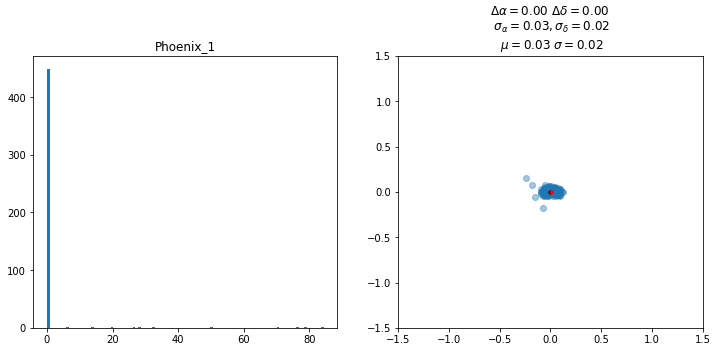

In [193]:
fnm = 'Phoenix_1'
get_offsets(fnm, 'external_catalogs/astrometric/{}_gaia.ecsv'.format(fnm), des_table=pho1_corrected, doplot=True)

They match - hooray!